# Hotel Booking Analysis with PySpark

Apache Spark is an open-source, distributed processing system used for big data workloads. Its high-level APIs available in differents languages like Python or Scala makes this framework appealling for many Data Scientists that need to handle large amounts of data. 

In this notebook, we are going to explore data of hotel booking from the public [hotel booking demand dataset](https://www.sciencedirect.com/science/article/pii/S2352340918315191) by using PySpark. The data contains "bookings due to arrive between the 1st of July of 2015 and the 31st of August 2017" for two hotels in Portugal. Both hotels are located in Portugal (southern Europe), where H1 is located at the resort region of Algarve and H2 is at the city of Lisbon. The distance between these two locations is ca. 280 km by car and both locations border on the north atlantic.

Not only will we explore the dataset, we will also try to explore the three sets of APIs available in Apache Spark which are RDDs, DataFrames, and Datasets.

## RDD
Though it's not as intuitive or efficient as using higher-level APIs, I will be using RDD to perform basic transformations and actions.

### Initializing a Spark Context

In [1]:
from pyspark import SparkContext, SparkConf

# Set up SparkConf and SparkContext
conf = SparkConf().setAppName("hotelbookings").setMaster("local[*]")
sc = SparkContext.getOrCreate(conf=conf)
sc

24/09/15 16:34:49 WARN Utils: Your hostname, Ulyas-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.0.19 instead (on interface en0)
24/09/15 16:34:49 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/15 16:34:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


<SparkContext master=local[*] appName=hotelbookings>

In [2]:
# Read the CSV file into an RDD
rdd = sc.textFile("./data/hotel_bookings.csv")
rdd.take(5)

['hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date',
 'Resort Hotel,0,342,2015,July,27,1,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NULL,NULL,0,Transient,0,0,0,Check-Out,2015-07-01',
 'Resort Hotel,0,737,2015,July,27,1,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NULL,NULL,0,Transient,0,0,0,Check-Out,2015-07-01',
 'Resort Hotel,0,7,2015,July,27,1,0,1,1,0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NULL,NULL,0,Transient,75,0,0,Check-Out,2015-07-02',
 'Resort Hotel,0,13,2015,July,27,1,0,1,1,0,0,BB,GBR,

In [3]:
# Split each line by comma
split_rdd = rdd.map(lambda line: line.split(","))

# Determine header
header = split_rdd.first()

# Extract data excluding the header
data_rdd = split_rdd.filter(lambda row: row != header)
data_rdd.take(1)

[['Resort Hotel',
  '0',
  '342',
  '2015',
  'July',
  '27',
  '1',
  '0',
  '0',
  '2',
  '0',
  '0',
  'BB',
  'PRT',
  'Direct',
  'Direct',
  '0',
  '0',
  '0',
  'C',
  'C',
  '3',
  'No Deposit',
  'NULL',
  'NULL',
  '0',
  'Transient',
  '0',
  '0',
  '0',
  'Check-Out',
  '2015-07-01']]

To make the data simpler, I will only use several columns in this RDD practice. The columns that I will work with are: `country`, `hotel`, `adults`, `children`, and `babies`.

### Simple Exploration

In [4]:
# Getting column to retain
simple_rdd = ["hotel", "adults", "children", "babies", "country"]

# Getting their indices
simple_indices = [header.index(col) for col in simple_rdd]

# Map to extract the values based on indices
extracted_rdd = data_rdd.map(lambda row: [row[i] for i in simple_indices])
extracted_rdd.take(5)

[['Resort Hotel', '2', '0', '0', 'PRT'],
 ['Resort Hotel', '2', '0', '0', 'PRT'],
 ['Resort Hotel', '1', '0', '0', 'GBR'],
 ['Resort Hotel', '1', '0', '0', 'GBR'],
 ['Resort Hotel', '2', '0', '0', 'GBR']]

In [5]:
# Count hotel based on its type

# Map each row to (category, 1) tuples
hotel_type = extracted_rdd.map(lambda row: (row[0], 1))

# Reduce by key to get the count of each category
hotel_type_counts = hotel_type.reduceByKey(lambda a, b: a + b)
hotel = hotel_type_counts.collect()

# Print results
for type, total_count in hotel:
    print(f"Type: {type}, Total: {total_count}")

Type: Resort Hotel, Total: 40060
Type: City Hotel, Total: 79330


We can observe City Hotel being more popular than resort hotel.

In [6]:
# Count the total of guest based on their age group

# Map each record to tuples with the sum of adults, children, and babies
adults_count = extracted_rdd.map(lambda row: int(row[1])).reduce(lambda a, b: a + b)
children_count = extracted_rdd.map(
    lambda row: int(row[2] if row[2] != "NA" else 0)
).reduce(lambda a, b: a + b)
babies_count = extracted_rdd.map(
    lambda row: int(row[3] if row[3] != "NA" else 0)
).reduce(lambda a, b: a + b)

# Collect the results
result = {"Adults": adults_count, "Children": children_count, "Babies": babies_count}

print(result)

{'Adults': 221636, 'Children': 12403, 'Babies': 949}


In [7]:
# Count distinct country that made reservation
country_list = extracted_rdd.map(lambda row: (row[4])).distinct()
country_list.count()

178

In [8]:
# Count reservation based on their country

# Map each row to (category, 1) tuples
guest_origin = extracted_rdd.map(lambda row: (row[4], 1))

# Reduce by key to get the count of each category
guest_origin_counts = guest_origin.reduceByKey(lambda a, b: a + b)
guest_origin_counts.sortBy(lambda x: x[1], ascending=False).collect()

[('PRT', 48590),
 ('GBR', 12129),
 ('FRA', 10415),
 ('ESP', 8568),
 ('DEU', 7287),
 ('ITA', 3766),
 ('IRL', 3375),
 ('BEL', 2342),
 ('BRA', 2224),
 ('NLD', 2104),
 ('USA', 2097),
 ('CHE', 1730),
 ('CN', 1279),
 ('AUT', 1263),
 ('SWE', 1024),
 ('CHN', 999),
 ('POL', 919),
 ('ISR', 669),
 ('RUS', 632),
 ('NOR', 607),
 ('ROU', 500),
 ('NULL', 488),
 ('FIN', 447),
 ('DNK', 435),
 ('AUS', 426),
 ('AGO', 362),
 ('LUX', 287),
 ('MAR', 259),
 ('TUR', 248),
 ('HUN', 230),
 ('ARG', 214),
 ('JPN', 197),
 ('CZE', 171),
 ('IND', 152),
 ('KOR', 133),
 ('GRC', 128),
 ('DZA', 103),
 ('SRB', 101),
 ('HRV', 100),
 ('MEX', 85),
 ('EST', 83),
 ('IRN', 83),
 ('LTU', 81),
 ('ZAF', 80),
 ('BGR', 75),
 ('NZL', 74),
 ('COL', 71),
 ('UKR', 68),
 ('MOZ', 67),
 ('SVK', 65),
 ('CHL', 65),
 ('THA', 59),
 ('SVN', 57),
 ('ISL', 57),
 ('LVA', 55),
 ('ARE', 51),
 ('CYP', 51),
 ('TWN', 51),
 ('SAU', 48),
 ('PHL', 40),
 ('TUN', 39),
 ('SGP', 39),
 ('IDN', 35),
 ('NGA', 34),
 ('URY', 32),
 ('EGY', 32),
 ('LBN', 31),
 ('HK

There are 178 countries that made reservation, and the highest is 'PRT' which is the alpha-3 code for Portugal with 48,590 bookings. Now let's compare the domestic guests (from Portugal) and international guests!

In [9]:
#  Filter only domestic guest
domestic = guest_origin_counts.filter(lambda x: x[0] == "PRT")
domestic_count = domestic.map(lambda x: x[1]).sum()

# Filter for non-domestic tourists
international = guest_origin_counts.filter(lambda x: x[0] != "PRT")
international_count = international.map(lambda x: x[1]).sum()

# Show result
print(f"Count of domestic guests (PRT): {domestic_count}")
print(f"Count of international guests: {international_count}")

Count of domestic guests (PRT): 48590
Count of international guests: 70800


Let's see the distribution of the international tourists by the continent. To do that, we have to take another dataset and join them by the country code.

In [10]:
# Taking country data for further analysis
country_rdd = sc.textFile("./data/country.csv")

# Split each line by comma
country_split = country_rdd.map(lambda line: line.split(","))

# Extract data excluding the header
country_header = country_split.first()
country = country_split.filter(lambda row: row != country_header)
country.take(1)

[['Afghanistan',
  'AF',
  'AFG',
  '004',
  'ISO 3166-2:AF',
  'Asia',
  'Southern Asia',
  '""',
  '142',
  '034',
  '""']]

In [11]:
# Take country code and continent
continent = country.map(lambda row: (row[2], row[5] if row[5] != '""' else row[0]))
continent.take(5)

[('AFG', 'Asia'),
 ('ALA', 'Europe'),
 ('ALB', 'Europe'),
 ('DZA', 'Africa'),
 ('ASM', 'Oceania')]

In [12]:
# Join continent data with international data
data_joined = continent.join(international)

# Extract continent and count
continent_counts = data_joined.map(lambda x: (x[1][0], x[1][1]))

# Sum counts by continent
continent_totals = continent_counts.reduceByKey(lambda a, b: a + b)

# Sort by count in descending order
sorted_continent_totals = continent_totals.sortBy(lambda x: x[1], ascending=False)

# Collect the results
results = sorted_continent_totals.collect()

# Print results
for continent, total_count in results:
    print(f"Continent: {continent}, Count: {total_count}")

Continent: Europe, Count: 57132
Continent: Americas, Count: 4946
Continent: Asia, Count: 2922
Continent: Africa, Count: 1109
Continent: Oceania, Count: 507
Continent: Antarctica, Count: 2


We received reservations from all over the world, but geographical location plays a significant role, with Europe having the largest number of bookings.

## Dataframe

To do more detailed analysis, we'll use DataFrame for its advanced features. To make things easier, I'll re-import the data into SparkSession.

### Create SparkSession and Load Data

In [13]:
# Create SparkSession
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local").appName("hotelbookings").getOrCreate()

# Data path
PATH = "./data/hotel_bookings.csv"

# Define the schema manually
from pyspark.sql.types import (
    StructType,
    StructField,
    StringType,
    FloatType,
    IntegerType,
    DateType,
)

schema = StructType(
    [
        StructField("hotel", StringType(), True),
        StructField("is_canceled", IntegerType(), True),
        StructField("lead_time", IntegerType(), True),
        StructField("arrival_date_year", IntegerType(), True),
        StructField("arrival_date_month", StringType(), True),
        StructField("arrival_date_week_number", IntegerType(), True),
        StructField("arrival_date_day_of_month", IntegerType(), True),
        StructField("stays_in_weekend_nights", IntegerType(), True),
        StructField("stays_in_week_nights", IntegerType(), True),
        StructField("adults", IntegerType(), True),
        StructField("children", IntegerType(), True),
        StructField("babies", IntegerType(), True),
        StructField("meal", StringType(), True),
        StructField("country", StringType(), True),
        StructField("market_segment", StringType(), True),
        StructField("distribution_channel", StringType(), True),
        StructField("is_repeated_guest", IntegerType(), True),
        StructField("previous_cancellations", IntegerType(), True),
        StructField("previous_bookings_not_canceled", IntegerType(), True),
        StructField("reserved_room_type", StringType(), True),
        StructField("assigned_room_type", StringType(), True),
        StructField("booking_changes", IntegerType(), True),
        StructField("deposit_type", StringType(), True),
        StructField("agent", StringType(), True),
        StructField("company", StringType(), True),
        StructField("days_in_waiting_list", IntegerType(), True),
        StructField("customer_type", StringType(), True),
        StructField("adr", FloatType(), True),
        StructField("required_car_parking_spaces", IntegerType(), True),
        StructField("total_of_special_requests", IntegerType(), True),
        StructField("reservation_status", StringType(), True),
        StructField("reservation_status_date", DateType(), True),
    ]
)

# Load data to schema
df = spark.read.csv(PATH, schema=schema, header=True)
df.printSchema()

root
 |-- hotel: string (nullable = true)
 |-- is_canceled: integer (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_date_year: integer (nullable = true)
 |-- arrival_date_month: string (nullable = true)
 |-- arrival_date_week_number: integer (nullable = true)
 |-- arrival_date_day_of_month: integer (nullable = true)
 |-- stays_in_weekend_nights: integer (nullable = true)
 |-- stays_in_week_nights: integer (nullable = true)
 |-- adults: integer (nullable = true)
 |-- children: integer (nullable = true)
 |-- babies: integer (nullable = true)
 |-- meal: string (nullable = true)
 |-- country: string (nullable = true)
 |-- market_segment: string (nullable = true)
 |-- distribution_channel: string (nullable = true)
 |-- is_repeated_guest: integer (nullable = true)
 |-- previous_cancellations: integer (nullable = true)
 |-- previous_bookings_not_canceled: integer (nullable = true)
 |-- reserved_room_type: string (nullable = true)
 |-- assigned_room_type: string (nulla

In [14]:
df.show(2)

24/09/15 16:35:09 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------------+-----------+---------+-----------------+------------------+------------------------+-------------------------+-----------------------+--------------------+------+--------+------+----+-------+--------------+--------------------+-----------------+----------------------+------------------------------+------------------+------------------+---------------+------------+-----+-------+--------------------+-------------+---+---------------------------+-------------------------+------------------+-----------------------+
|       hotel|is_canceled|lead_time|arrival_date_year|arrival_date_month|arrival_date_week_number|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|adults|children|babies|meal|country|market_segment|distribution_channel|is_repeated_guest|previous_cancellations|previous_bookings_not_canceled|reserved_room_type|assigned_room_type|booking_changes|deposit_type|agent|company|days_in_waiting_list|customer_type|adr|required_car_parking_spaces|total_of

The dataset contains 32 variables:
- `hotel`: whether it is a city hotel or a resort
- `is_canceled`: Value indicating if the booking was canceled (1) or not (0)
- `lead_time`: Number of days that elapsed between the entering date of the booking into the PMS and the arrival date
- `arrival_date_year`: Year of arrival date
- `arrival_date_month`: Month of arrival date
- `arrival_date_week_number`: Week number of year for arrival date
- `arrival_date_day_of_month`: Day of arrival date
- `stays_in_weekend_nights`: Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel
- `stays_in_week_nights`: Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel
- `adults`: Number of adults
- `children`: Number of children
- `babies`: Number of babies
- `meal`: Type of meal booked. Categories are presented in standard hospitality meal packages: Undefined/SC – no meal package; BB – Bed & Breakfast; HB – Half board (breakfast and one other meal – usually dinner); FB – Full board (breakfast, lunch and dinner)
- `country`: Country of origin. Categories are represented in the ISO 3155–3:2013 format
- `market_segment`: Market segment designation. In categories, the term “TA” means “Travel Agents” and “TO” means “Tour Operators”
- `distribution_channel`: Booking distribution channel. The term “TA” means “Travel Agents” and “TO” means “Tour Operators
- `isrepeated_guest`: Value indicating if the booking name was from a repeated guest (1) or not (0)
- `previous_cancellations`: Number of previous bookings that were cancelled by the customer prior to the current booking
- `previous_bookings_not_canceled`: Number of previous bookings not cancelled by the customer prior to the current booking
- `reserved_room_type`: Code of room type reserved. Code is presented instead of designation for anonymity reasons
- `assigned_room_type`: Code for the type of room assigned to the booking. Sometimes the assigned room type differs from the reserved room type due to hotel operation reasons (e.g. overbooking) or by customer request. Code is presented instead of designation for anonymity reasons.
- `booking_changes`: Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation
- `deposit_type`: Indication on if the customer made a deposit to guarantee the booking. This variable can assume three categories: No Deposit, Non Refund (a deposit was made in the value of the total stay cost) and Refundable (a deposit was made with a value under the total cost of stay).
- `agent`: ID of the travel agency that made the booking
- `company`: ID of the company/entity that made the booking or responsible for paying the booking. ID is presented instead of designation for anonymity reasons
- `days_in_waiting_list`: Number of days the booking was in the waiting list before it was confirmed to the customer
- `customer_type`: Type of booking, assuming one of four categories: Contract (when the booking has an allotment or other type of contract associated to it), Group, Transient (when the booking is not part of a group or contract, and is not associated to other transient booking) and Transient-party (when the booking is transient, but is associated to at least other transient booking)
- `adr`: Average Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights
- `required_car_parking_spaces`: Number of car parking spaces required by the customer
- `total_of_special_requests`: Number of special requests made by the customer (e.g. twin bed or high floor)
- `reservation_status`: Reservation last status, assuming one of three categories: Canceled – booking was canceled by the customer; Check-Out – customer has checked in but already departed; No-Show – customer did not check-in and did inform the hotel of the reason why
- `reservation_status_date`: Date at which the last status was set. This variable can be used in conjunction with the ReservationStatus to understand when was the booking canceled or when did the customer checked-out of the hotel

### Data Pre-processing

In [15]:
# describe the dataset
df.describe().toPandas().T

,0,1,2,3,4
summary,count,mean,stddev,min,max
hotel,119390,None,None,City Hotel,Resort Hotel
is_canceled,119390,0.37041628277075134,0.4829182265925992,0,1
lead_time,119390,104.01141636652986,106.86309704798789,0,737
arrival_date_year,119390,2016.156554150264,0.7074759445197123,2015,2017
arrival_date_month,119390,None,None,April,September
arrival_date_week_number,119390,27.16517296255968,13.605138355497637,1,53
arrival_date_day_of_month,119390,15.798241058715135,8.780829470578368,1,31
stays_in_weekend_nights,119390,0.9275986263506156,0.9986134945978752,0,19
stays_in_week_nights,119390,2.500301532791691,1.9082856150479115,0,50


The `.describe()` method gives us a good overview of the dataset. Based on the table above, we can observe some of the columns need further checks. Observation:
* We have 119,390 rows of data of hotel booking from 2015 to 2017. 
* The room can be book in the day, shown by minimum 0 in `lead_time` and can be as long as 737 days before (almost 2 years). Though it was a long time, it is still believable especially if the hotel is popular
* While arrival date related data (`arrival_date_year` etc) may be interesting for analyzing seasonality, I will combine those columns to be `arrival_date`
* There are missing values in `children` and we have NULL values in `company` and `agent`. I think NULL values in both columns are acceptable since the booking can be done without a company or agent. For the missing value in `children`, we can assume it to be 0.
* The minimum values of both `stays_in_weekend_nights` and `stays_in_week_nights` are 0. While it may be acceptable for one of them to be 0, having both at 0 simultaneously means no rooms were booked.
* The minimum values of `adults` is 0. This is also not accptable because we need at least 1 adult to book the room
* The minimum valus of `adr` is less than 0. Since adr is avarage daily rate, it can be less than 0.

In [16]:
from pyspark.sql import functions as F

# Create new column for month in numerical format
# Create and broadcast the month-to-number mapping dictionary
month_to_number = {
    "January": 1,
    "February": 2,
    "March": 3,
    "April": 4,
    "May": 5,
    "June": 6,
    "July": 7,
    "August": 8,
    "September": 9,
    "October": 10,
    "November": 11,
    "December": 12,
}


# Define the UDF to map month names to numbers
def month_to_number_udf(month_name):
    return month_to_number.get(month_name, None)


# Register the UDF
month_to_number_spark_udf = F.udf(month_to_number_udf, IntegerType())

In [17]:
# Update the DataFrame to change month names to their corresponding numbers
updated_df = df.withColumn(
    "month", month_to_number_spark_udf(F.col("arrival_date_month"))
)

# Show the resulting DataFrame
updated_df.show(5)

+------------+-----------+---------+-----------------+------------------+------------------------+-------------------------+-----------------------+--------------------+------+--------+------+----+-------+--------------+--------------------+-----------------+----------------------+------------------------------+------------------+------------------+---------------+------------+-----+-------+--------------------+-------------+----+---------------------------+-------------------------+------------------+-----------------------+-----+
|       hotel|is_canceled|lead_time|arrival_date_year|arrival_date_month|arrival_date_week_number|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|adults|children|babies|meal|country|market_segment|distribution_channel|is_repeated_guest|previous_cancellations|previous_bookings_not_canceled|reserved_room_type|assigned_room_type|booking_changes|deposit_type|agent|company|days_in_waiting_list|customer_type| adr|required_car_parking_spaces|

In [18]:
# Check missing value in children
df_children = updated_df.where(df["children"].isNull())
df_children.show()

+----------+-----------+---------+-----------------+------------------+------------------------+-------------------------+-----------------------+--------------------+------+--------+------+----+-------+--------------+--------------------+-----------------+----------------------+------------------------------+------------------+------------------+---------------+------------+-----+-------+--------------------+---------------+----+---------------------------+-------------------------+------------------+-----------------------+-----+
|     hotel|is_canceled|lead_time|arrival_date_year|arrival_date_month|arrival_date_week_number|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|adults|children|babies|meal|country|market_segment|distribution_channel|is_repeated_guest|previous_cancellations|previous_bookings_not_canceled|reserved_room_type|assigned_room_type|booking_changes|deposit_type|agent|company|days_in_waiting_list|  customer_type| adr|required_car_parking_spaces|

All data looks good, we can easily change the null with 0, meaning there is no children staying in those bookings.

In [19]:
from pyspark.sql.functions import col, sum

# Replace NULL values with 0 in specific columns
df_no_nulls = updated_df.fillna({"children": 0})
df_no_nulls.show(5)

+------------+-----------+---------+-----------------+------------------+------------------------+-------------------------+-----------------------+--------------------+------+--------+------+----+-------+--------------+--------------------+-----------------+----------------------+------------------------------+------------------+------------------+---------------+------------+-----+-------+--------------------+-------------+----+---------------------------+-------------------------+------------------+-----------------------+-----+
|       hotel|is_canceled|lead_time|arrival_date_year|arrival_date_month|arrival_date_week_number|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|adults|children|babies|meal|country|market_segment|distribution_channel|is_repeated_guest|previous_cancellations|previous_bookings_not_canceled|reserved_room_type|assigned_room_type|booking_changes|deposit_type|agent|company|days_in_waiting_list|customer_type| adr|required_car_parking_spaces|

In [20]:
# Count null values for each column
null_counts_df = df_no_nulls.select(
    [sum(col(c).isNull().cast("int")).alias(c) for c in df_no_nulls.columns]
)
null_counts_df.show()

+-----+-----------+---------+-----------------+------------------+------------------------+-------------------------+-----------------------+--------------------+------+--------+------+----+-------+--------------+--------------------+-----------------+----------------------+------------------------------+------------------+------------------+---------------+------------+-----+-------+--------------------+-------------+---+---------------------------+-------------------------+------------------+-----------------------+-----+
|hotel|is_canceled|lead_time|arrival_date_year|arrival_date_month|arrival_date_week_number|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|adults|children|babies|meal|country|market_segment|distribution_channel|is_repeated_guest|previous_cancellations|previous_bookings_not_canceled|reserved_room_type|assigned_room_type|booking_changes|deposit_type|agent|company|days_in_waiting_list|customer_type|adr|required_car_parking_spaces|total_of_special

Now we need to check the unusual data.

In [21]:
from pyspark.sql import functions as F

# Select several columns to check
df_selected = updated_df.select(
    "hotel",
    "lead_time",
    "stays_in_weekend_nights",
    "stays_in_week_nights",
    "adults",
    "children",
    "babies",
    "adr",
)
df_selected_sorted = df_selected.orderBy(F.col("adr").desc())
df_selected_sorted.show(5)

+------------+---------+-----------------------+--------------------+------+--------+------+------+
|       hotel|lead_time|stays_in_weekend_nights|stays_in_week_nights|adults|children|babies|   adr|
+------------+---------+-----------------------+--------------------+------+--------+------+------+
|  City Hotel|       35|                      0|                   1|     2|       0|     0|5400.0|
|  City Hotel|        0|                      0|                   1|     1|       0|     0| 510.0|
|Resort Hotel|        1|                      0|                   1|     2|       0|     0| 508.0|
|  City Hotel|       81|                      1|                   1|     2|       2|     0| 451.5|
|Resort Hotel|      378|                      4|                  10|     2|       0|     0| 450.0|
+------------+---------+-----------------------+--------------------+------+--------+------+------+
only showing top 5 rows



The maximum value of ADR is significantly higher compared to other values with the same duration, which I believe is due to an input error. Therefore, I will correct the value from 5400 to 540.

In [22]:
# Update the DataFrame
updated_adr_df = df_no_nulls.withColumn(
    "adr", F.when(F.col("adr") == 5400, 540).otherwise(F.col("adr"))
)

# Show the resulting DataFrame
updated_adr_df.show(5)

+------------+-----------+---------+-----------------+------------------+------------------------+-------------------------+-----------------------+--------------------+------+--------+------+----+-------+--------------+--------------------+-----------------+----------------------+------------------------------+------------------+------------------+---------------+------------+-----+-------+--------------------+-------------+----+---------------------------+-------------------------+------------------+-----------------------+-----+
|       hotel|is_canceled|lead_time|arrival_date_year|arrival_date_month|arrival_date_week_number|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|adults|children|babies|meal|country|market_segment|distribution_channel|is_repeated_guest|previous_cancellations|previous_bookings_not_canceled|reserved_room_type|assigned_room_type|booking_changes|deposit_type|agent|company|days_in_waiting_list|customer_type| adr|required_car_parking_spaces|

In [23]:
# Check booking with no stay duration info
df_stay_inspect = df.where(
    (df["stays_in_weekend_nights"] == 0) & (df["stays_in_week_nights"] == 0)
)
percentage = (df_stay_inspect.count() / df.count()) * 100
percentage

0.5988776279420387

In [24]:
# Check booking with no adults
df_adults_inspect = df.where(df["adults"] == 0)
percentage = (df_adults_inspect.count() / df.count()) * 100
percentage

0.33754920847642184

In [25]:
# Check booking with adr less than 0
df_adr_inspect = df.where(df["adr"] < 0)
percentage = (df_adr_inspect.count() / df.count()) * 100
percentage

0.0008375910880308232

Since the strange data is less than 1% of our data, it's safe to just remove them and now we're left with 117,182 rows of data!

In [26]:
from pyspark.sql.functions import col

# Apply the first filter: Keep rows where both 'stays_in_weekend_nights' and 'stays_in_week_nights' are not zero
df_cleaned = updated_adr_df.filter(
    ~((col("stays_in_weekend_nights") == 0) & (col("stays_in_week_nights") == 0))
    & (col("adults") != 0)
    & (col("adr") > 0)
)

# Show the number of rows after cleaning
df_cleaned_count = df_cleaned.count()
print(f"Number of rows after cleaning: {df_cleaned.count()}")

Number of rows after cleaning: 117182


### Descriptive Analysis

In [27]:
# separate numerical and categorical columns
numericals = [
    "lead_time",
    "arrival_date_year",
    "month",
    "arrival_date_week_number",
    "arrival_date_day_of_month",
    "stays_in_weekend_nights",
    "stays_in_week_nights",
    "adults",
    "children",
    "babies",
    "previous_cancellations",
    "previous_bookings_not_canceled",
    "booking_changes",
    "days_in_waiting_list",
    "adr",
    "required_car_parking_spaces",
    "total_of_special_requests",
    "reservation_status_date",
]

categoricals = [
    "hotel",
    "is_canceled",
    "meal",
    "country",
    "market_segment",
    "distribution_channel",
    "is_repeated_guest",
    "reserved_room_type",
    "assigned_room_type",
    "deposit_type",
    "agent",
    "company",
    "customer_type",
    "reservation_status",
]

numerical_spark = df_cleaned.select(*numericals)
numerical_df = numerical_spark.toPandas()

categorical_spark = df_cleaned.select(*categoricals)
categorical_df = categorical_spark.toPandas()

In [28]:
# import library to make visualization

import matplotlib.pyplot as plt
import seaborn as sns

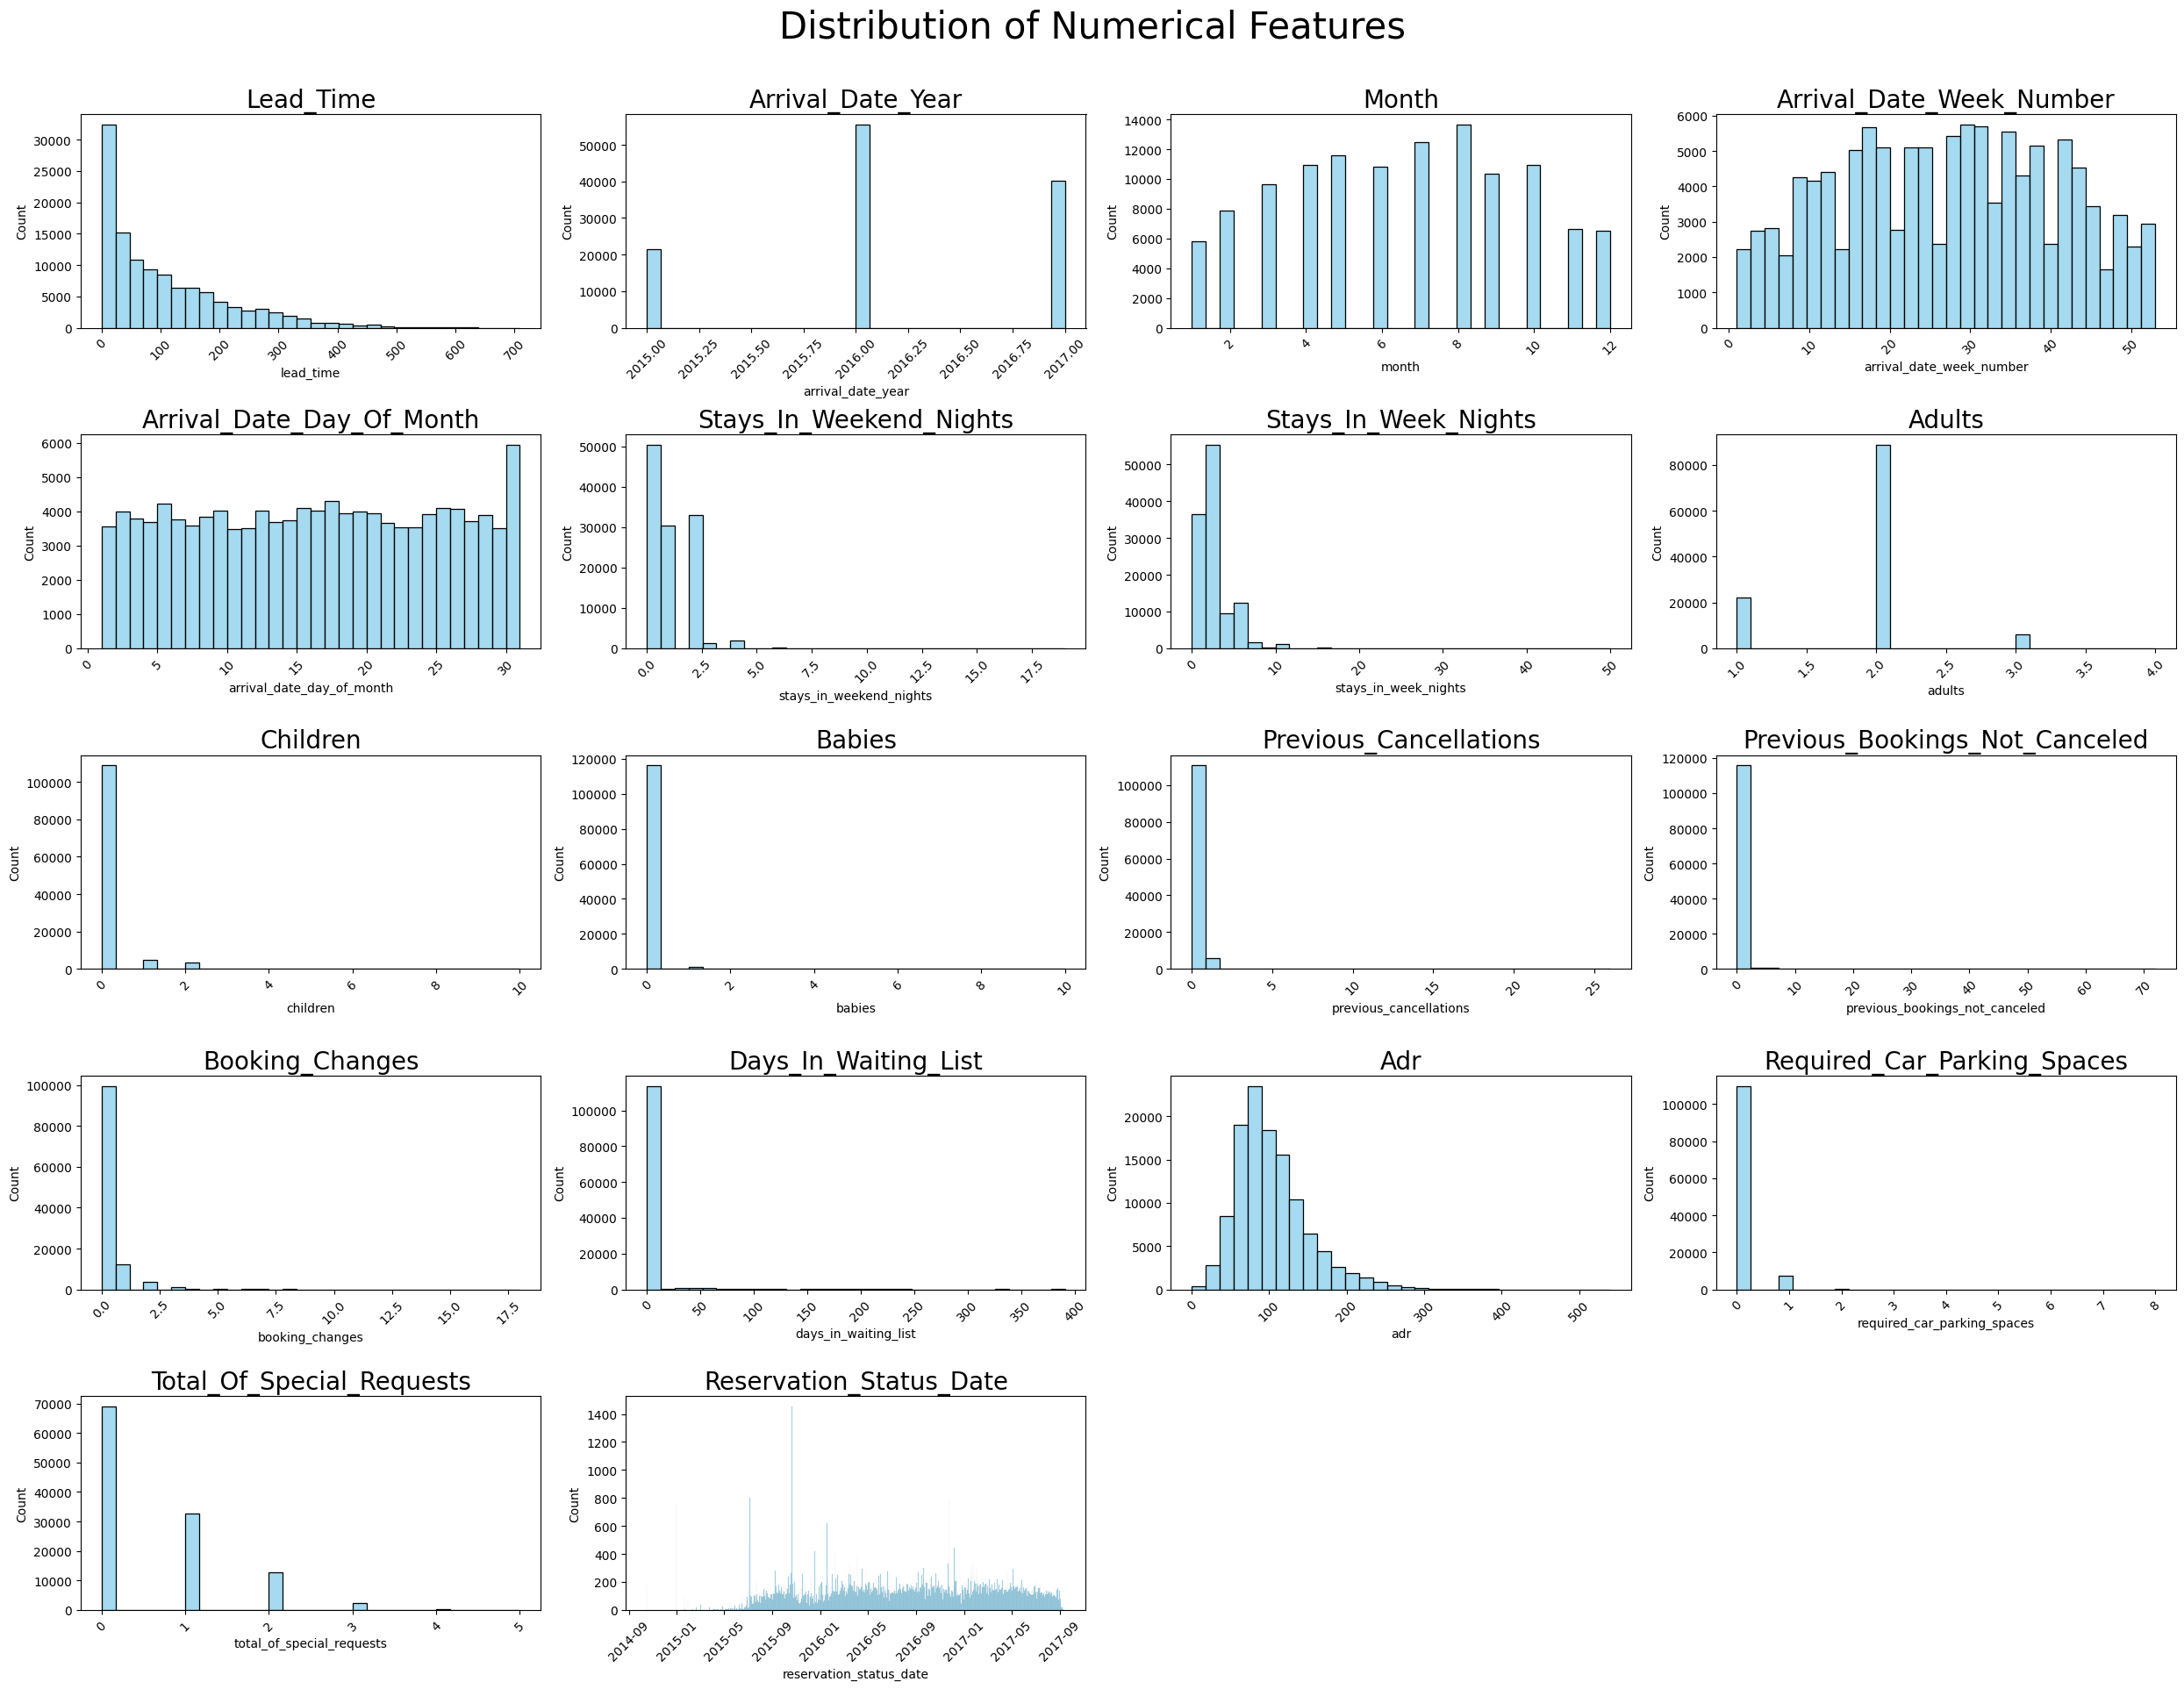

In [29]:
# Create figure and subplots for every columns in dataframe
fig = plt.figure(figsize=(25, 20))
st = fig.suptitle(
    "Distribution of Numerical Features", fontsize=30, verticalalignment="center"
)

# Create subplots for each numerical column
for num, col in enumerate(numerical_df.columns, start=1):
    ax = fig.add_subplot(5, 4, num)  # Create subplots
    sns.histplot(numerical_df[col], bins=30, kde=False, ax=ax, color="skyblue")
    ax.set_title(col.title(), fontsize=20)
    ax.tick_params(axis="x", rotation=45)
    plt.grid(False)

plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.9, hspace=0.5)

plt.show()

From the visualization above, we can observe:

* Many bookings have 0 lead time, meaning that people tend to book their hotel close to the time they will stay
* There is seasonality shown by the week, likely related to weekends and weekdays
* There are many columns that have low variety which makes them almost look like a categorical column

Unlike Pandas Dataframe, there are no description method for categorical data, so I make my own function to show the distinct value, mode and count of mode for the data.

In [30]:
from pyspark.sql.functions import count, desc

# Initialize a list to store results
results = []

for column in categoricals:
    # Count distinct values
    distinct_count = categorical_spark.select(F.col(column)).distinct().count()

    # Find the mode (most frequent value)
    value_counts = categorical_spark.groupBy(F.col(column)).agg(
        count("*").alias("count")
    )
    mode = value_counts.orderBy(desc("count")).first()

    # Extract mode value and count
    mode_value = mode[column] if mode else None
    mode_count = mode["count"] if mode else 0

    # Append the results to the list
    results.append((column, distinct_count, mode_value, mode_count))

# Create a DataFrame from the results
results_df = spark.createDataFrame(
    results, ["Column", "Distinct_Count", "Mode", "Mode_Count"]
)

# Show the results DataFrame
results_df.toPandas()

,Column,Distinct_Count,Mode,Mode_Count
0,hotel,2,City Hotel,77875
1,is_canceled,2,0,73253
2,meal,5,BB,90597
3,country,178,PRT,46989
4,market_segment,8,Online TA,55903
5,distribution_channel,5,TA/TO,96700
6,is_repeated_guest,2,0,113912
7,reserved_room_type,9,A,84545
8,assigned_room_type,11,A,73174
9,deposit_type,3,No Deposit,102433


Since `country`, `agent`, and `company` has so much variety, I will filter them when making overall visualization

In [31]:
# List of columns to drop
columns_to_drop = ["country", "agent", "company"]

# Drop the unwanted columns
filtered_categorical = (categorical_spark).drop(*columns_to_drop).toPandas()

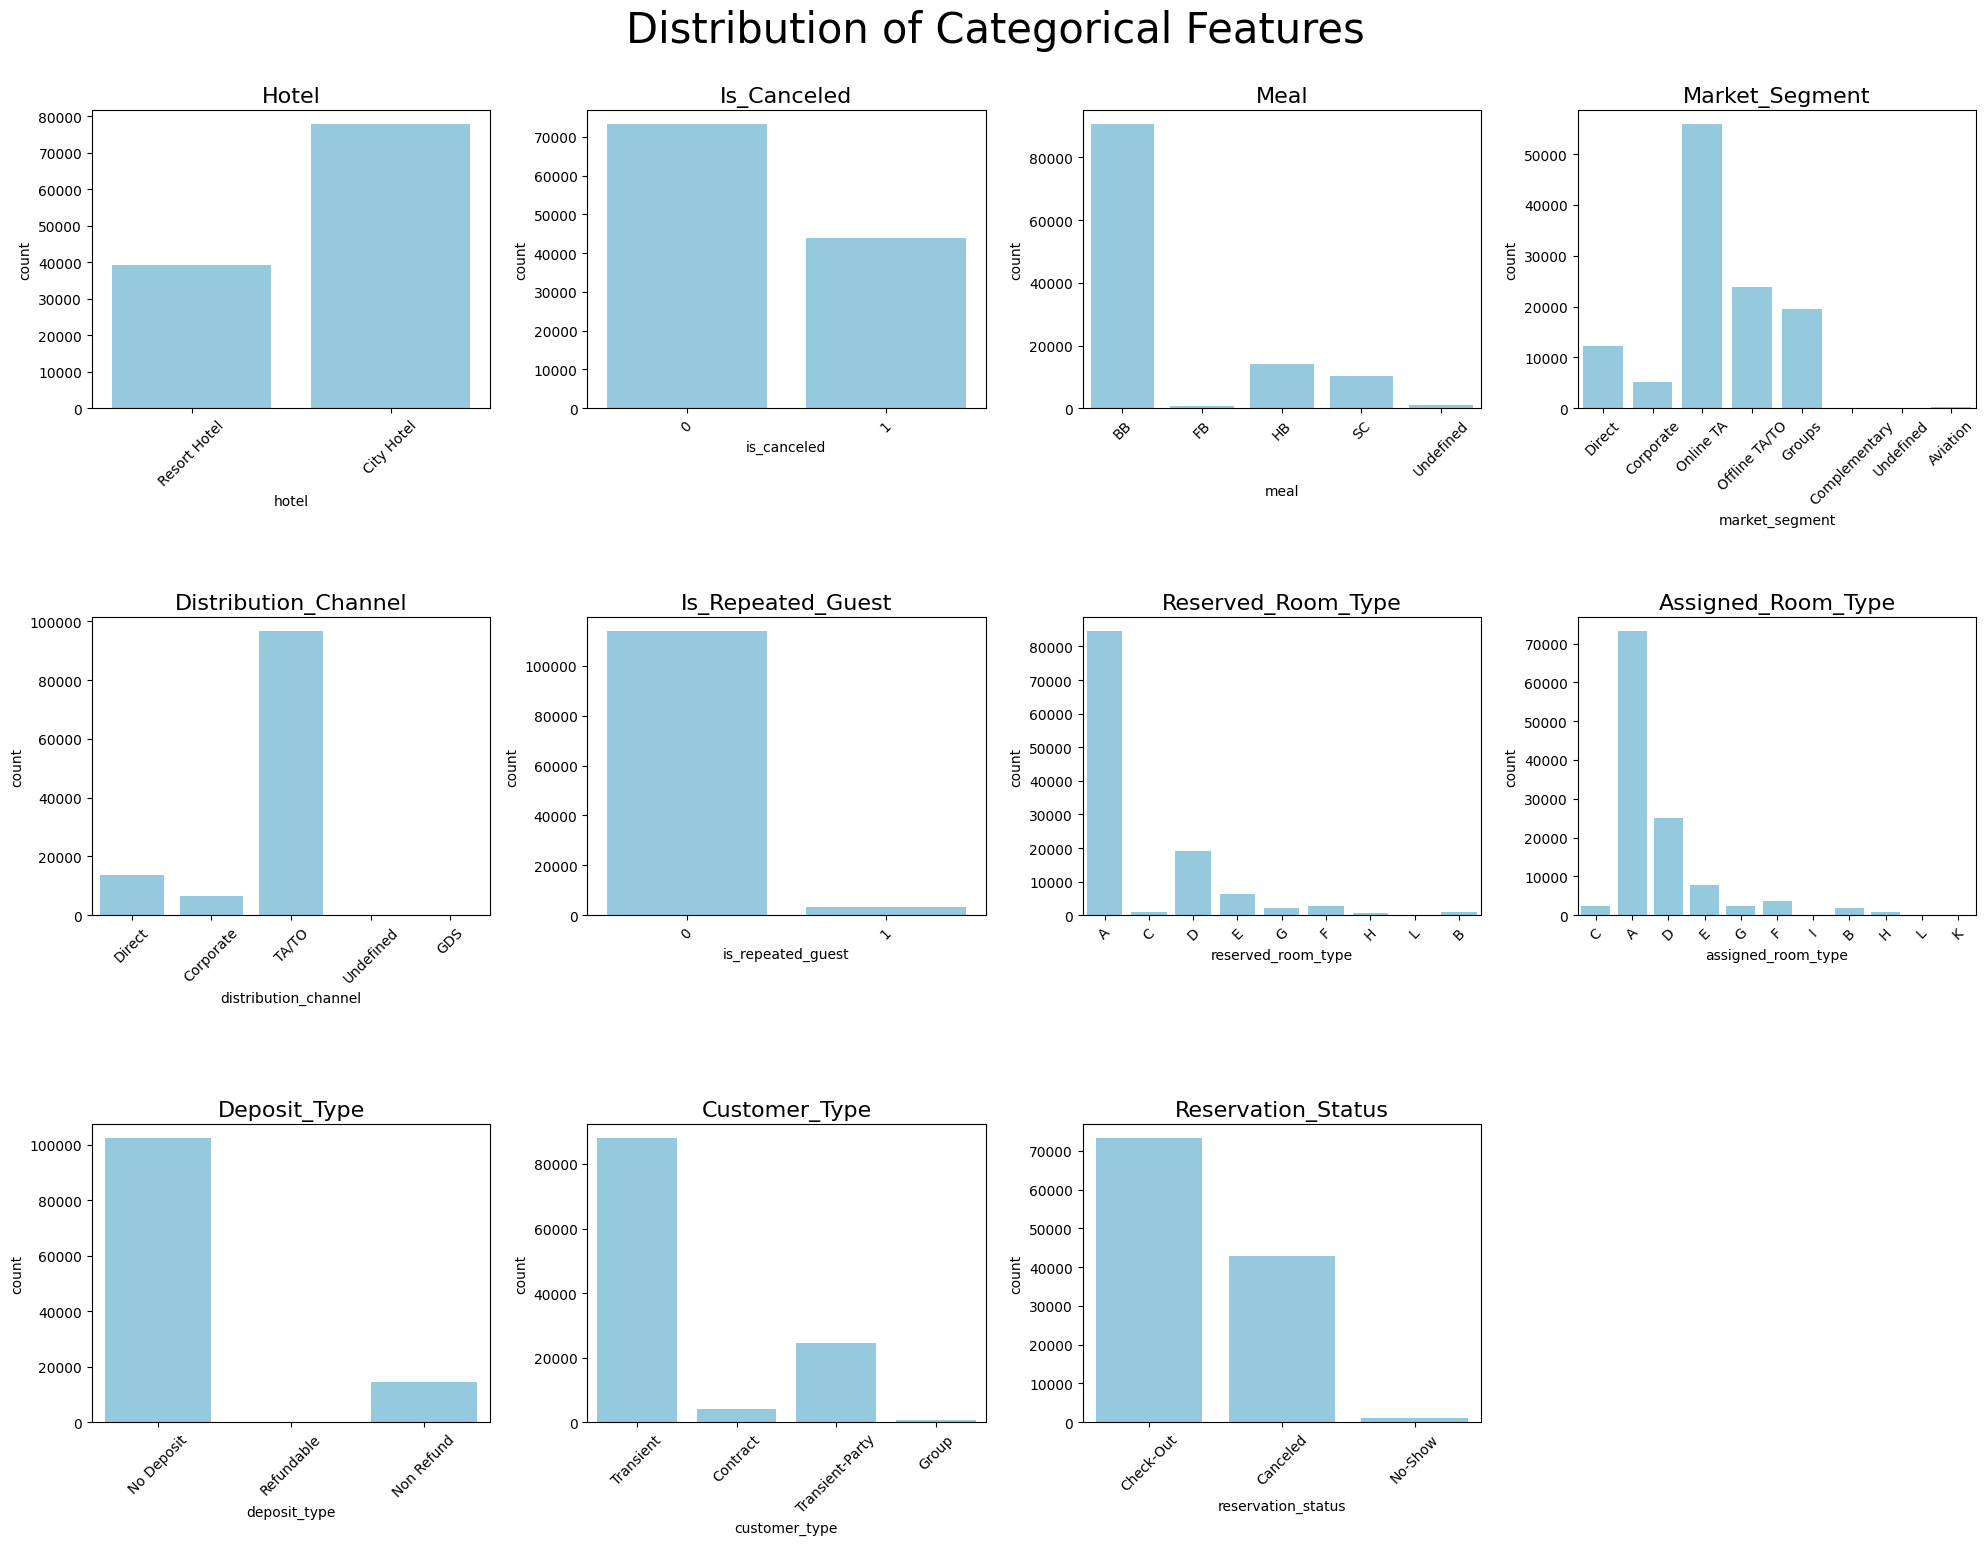

In [32]:
# Create figure and subplots
fig = plt.figure(figsize=(20, 16))
st = fig.suptitle(
    "Distribution of Categorical Features", fontsize=30, verticalalignment="center"
)

# Create subplots for each categorical columns
for num, col in enumerate(filtered_categorical.columns, start=1):
    ax = fig.add_subplot(3, 4, num)  # Create subplots
    sns.countplot(
        x=filtered_categorical[col], ax=ax, color="skyblue"
    )  # Use seaborn countplot for discrete data
    ax.set_title(col.title(), fontsize=16)
    ax.tick_params(axis="x", rotation=45)
    plt.grid(False)

# Adjust layout to avoid overlap
plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.9, hspace=0.7)

# Display the plot
plt.show()

From the visualisation above, we can observe:
* City hotels are twice as popular as resort hotels
* A significant number of people are canceling their bookings. We need to learn what makes them cancel their booking and try to prevent it!
* There are higher bookings during summer months (July-August) compared to the winter (December). This indicates a seasonal pattern that we will explore further.
* Certain categories appear to be more dominant than others, such as BB for meal type, Online Travel Agents, new guests, room type A, and Transient. This information can help us understand the demand for hotels in Portugal and strategize to maximize our profit.

### Identify Factors Associated with Booking Cancelation

First, let’s examine the number of cancellations for both hotels. This will help us assess each hotel's performance and understand why potential customers may cancel their bookings.

In [33]:
# Calculate the total count by hotel
total_by_hotel = (
    df_cleaned.groupBy("hotel").count().withColumnRenamed("count", "total_count")
)

# Grouping data
grouped_df = df_cleaned.groupBy("hotel", "is_canceled").count()

# Join the grouped data with total counts
joined_df = grouped_df.join(total_by_hotel, on="hotel")

# Calculate the percentage
percentage_hotel = joined_df.withColumn(
    "percentage", F.round(F.col("count") / F.col("total_count") * 100, 2)
)

percentage_hotel.show()

+------------+-----------+-----+-----------+----------+
|       hotel|is_canceled|count|total_count|percentage|
+------------+-----------+-----+-----------+----------+
|Resort Hotel|          1|11038|      39307|     28.08|
|Resort Hotel|          0|28269|      39307|     71.92|
|  City Hotel|          1|32891|      77875|     42.24|
|  City Hotel|          0|44984|      77875|     57.76|
+------------+-----------+-----+-----------+----------+



In [34]:
# Export to pandas to make visualization
percentage_hotel_pd = percentage_hotel.toPandas()
percentage_hotel_pd

,hotel,is_canceled,count,total_count,percentage
0,Resort Hotel,1,11038,39307,28.08
1,Resort Hotel,0,28269,39307,71.92
2,City Hotel,1,32891,77875,42.24
3,City Hotel,0,44984,77875,57.76


<Axes: xlabel='hotel', ylabel='count'>

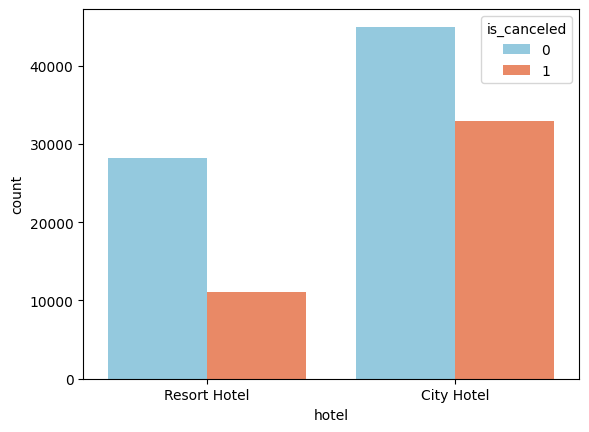

In [35]:
# Plotting a bar graph
sns.barplot(
    data=percentage_hotel_pd,
    x="hotel",
    y="count",
    hue="is_canceled",
    palette=["skyblue", "coral"],
)

Based on this, we can see that city hotels have a higher number of cancelation. 41.76% of the total bookings cancel their bookings. Meanwhile resorts show better performance because 27.76% bookings got cancelled. Though it was lower compared to city hotel, the number is still concerning and we need to do something about it. Now let's check how other categorical features related to the number of bookings that got cancelled.

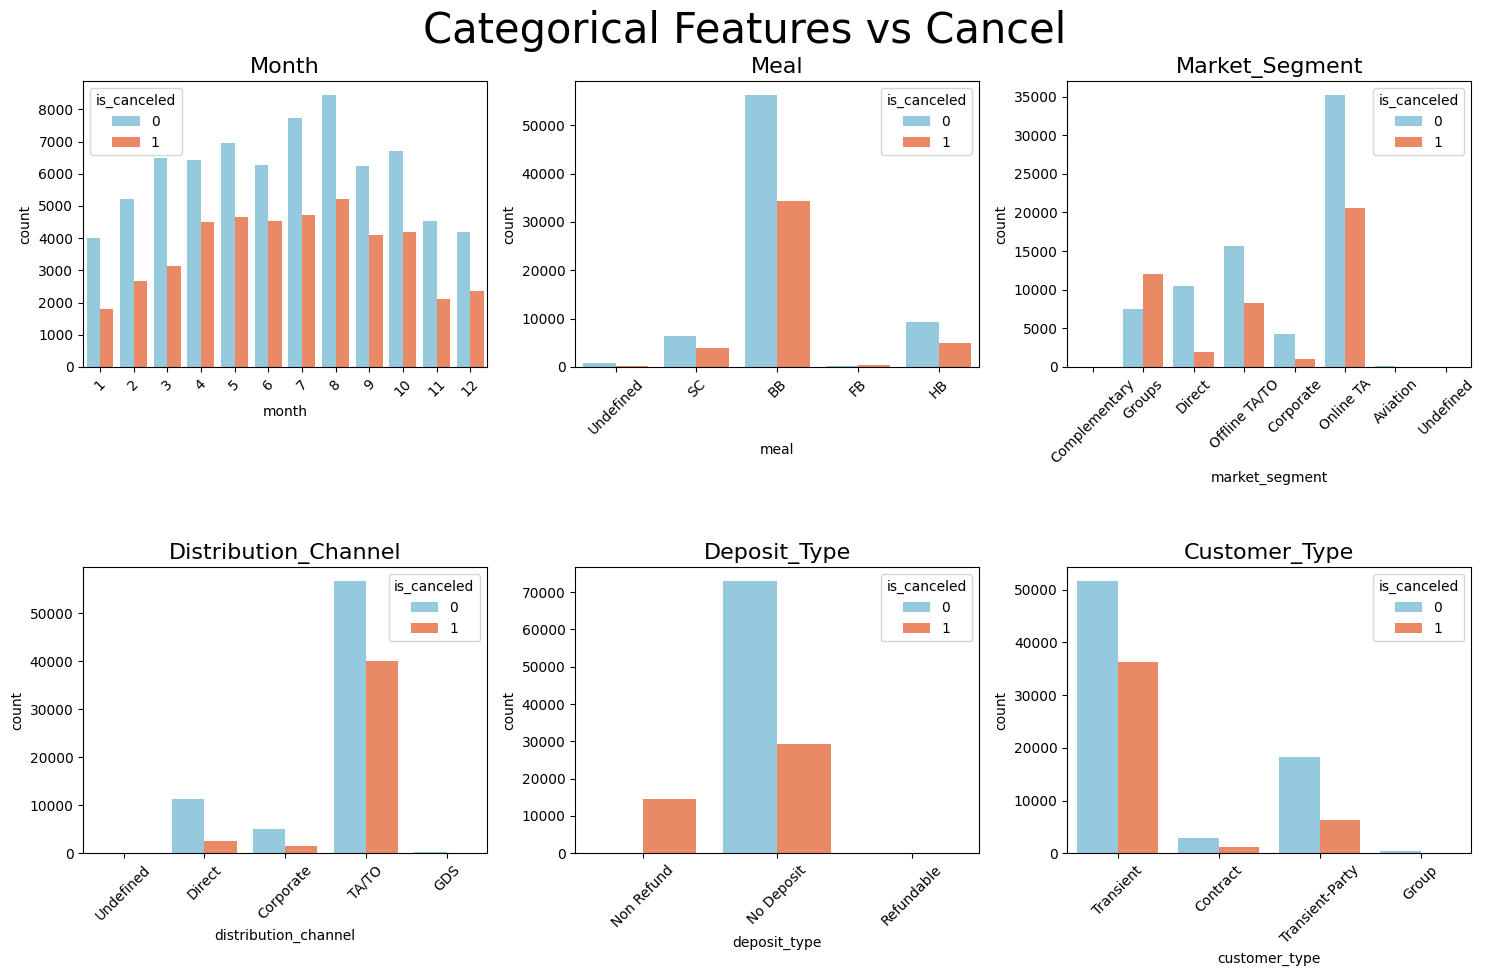

In [36]:
# select categorical column to further analysis
columns_cancel = [
    "month",
    "meal",
    "market_segment",
    "distribution_channel",
    "deposit_type",
    "customer_type",
]

# Create figure and subplots
fig = plt.figure(figsize=(15, 10))
st = fig.suptitle(
    "Categorical Features vs Cancel", fontsize=30, verticalalignment="center"
)

# Create subplots for each categorical columns
for i in range(0, len(columns_cancel)):
    ax = fig.add_subplot(2, 3, i + 1)
    data_pd = df_cleaned.groupBy(columns_cancel[i], "is_canceled").count().toPandas()
    sns.barplot(
        data_pd,
        x=columns_cancel[i],
        y="count",
        hue="is_canceled",
        palette=["skyblue", "coral"],
    )
    ax.set_title(columns_cancel[i].title(), fontsize=16)
    ax.tick_params(axis="x", rotation=45)
    plt.grid(False)

# Adjust layout to avoid overlap
plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.9, hspace=0.7)

# Display the plot
plt.show()

Observations:
* Values with more bookings also tend to have more cancellations. Analyzing the cancellation rate in relation to the number of bookings would be useful, as the total number of bookings varies.
* The monthly distribution shows a spread across each month. It would be interesting to investigate whether this distribution affects cancellation rates.
* Based on market segment, groups have a higher cancellation rate compared to individuals who show up. This difference warrants further investigation.
* Based on the deposit type, we note that all non-refundable reservations were canceled. This suggests that the absence of a deposit is not the reason for cancellations, so we should explore other factors.

#### Hypothesis Testing

Because we see interesting findings in market_segment, I want to perform a Chi-Square Test for this feature with cancelation.  
H0 = There is no association between the two categorical features (`market_segment` and `is_canceled`)  
H1 = There is association between the two categorical features (`market_segment` and `is_canceled`)

In [37]:
# check whether market_segment has correlation with the booking getting canceled

from pyspark.sql import functions as F

ht = df_cleaned.select("market_segment", "is_canceled")
ht = df_cleaned.filter(ht.market_segment != "Undefined")

cross_tab = ht.stat.crosstab("market_segment", "is_canceled")

contingency_table = cross_tab.toPandas()
contingency_table = contingency_table[["0", "1"]]
contingency_table

,0,1
0,15612,8270
1,57,5
2,180,51
3,10438,1896
4,4224,987
5,35258,20645
6,7484,12073


In [38]:
from scipy.stats import chi2_contingency

# Perform the chi-square test
chi2, p_value, degrees_of_freedom, expected_frequencies = chi2_contingency(
    contingency_table
)

# Print the results
print(f"Chi-Square Statistic: {chi2:.2f}")
print(f"P-Value: {p_value:.2f}")
print("Degrees of Freedom:", degrees_of_freedom)

Chi-Square Statistic: 8381.72
P-Value: 0.00
Degrees of Freedom: 6


Because the P-Value is < 0.05, we can confidently reject the null hypothesis and conclude that there is a significant assosociation netween `market_segment` and `is_canceled`. However, since we have a large chi-square statistic, it indicates a greater discrepancy between the observed and expected frequencies.

#### Correlation

In [39]:
corr_cols = [
    "is_canceled",
    "lead_time",
    "arrival_date_year",
    "month",
    "arrival_date_day_of_month",
    "stays_in_weekend_nights",
    "stays_in_week_nights",
    "adults",
    "children",
    "babies",
    "is_repeated_guest",
    "previous_cancellations",
    "previous_bookings_not_canceled",
    "booking_changes",
    "days_in_waiting_list",
    "adr",
    "required_car_parking_spaces",
    "total_of_special_requests",
]  # I don't include arrival_date_week_number because it is basically the same as month

corr_df = df_cleaned.select(corr_cols)
corr_df.show(5)

+-----------+---------+-----------------+-----+-------------------------+-----------------------+--------------------+------+--------+------+-----------------+----------------------+------------------------------+---------------+--------------------+-----+---------------------------+-------------------------+
|is_canceled|lead_time|arrival_date_year|month|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|adults|children|babies|is_repeated_guest|previous_cancellations|previous_bookings_not_canceled|booking_changes|days_in_waiting_list|  adr|required_car_parking_spaces|total_of_special_requests|
+-----------+---------+-----------------+-----+-------------------------+-----------------------+--------------------+------+--------+------+-----------------+----------------------+------------------------------+---------------+--------------------+-----+---------------------------+-------------------------+
|          0|        7|             2015|    7|                    

In [40]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

In [41]:
vector_col = "corr_vars"
assembler = VectorAssembler(inputCols=corr_df.columns, outputCol=vector_col)
df_vector = assembler.transform(corr_df).select(vector_col)
corr_matrix = Correlation.corr(df_vector, vector_col).collect()[0][0].toArray().tolist()

24/09/15 16:36:39 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [42]:
corr_matrix_df = spark.createDataFrame(corr_matrix, corr_df.columns)
corr_matrix_df.show()

+--------------------+--------------------+--------------------+--------------------+-------------------------+-----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------------+------------------------------+--------------------+--------------------+--------------------+---------------------------+-------------------------+
|         is_canceled|           lead_time|   arrival_date_year|               month|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|              adults|            children|              babies|   is_repeated_guest|previous_cancellations|previous_bookings_not_canceled|     booking_changes|days_in_waiting_list|                 adr|required_car_parking_spaces|total_of_special_requests|
+--------------------+--------------------+--------------------+--------------------+-------------------------+-----------------------+--------------------+--------------------

In [43]:
plot_corr = corr_matrix_df.toPandas()
plot_corr.index = corr_matrix_df.columns
plot_corr.style.background_gradient(cmap="RdBu_r")

,is_canceled,lead_time,arrival_date_year,month,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
is_canceled,1.000000,0.290611,0.013970,0.012493,-0.006267,-0.006923,0.018699,0.057172,0.004390,-0.032531,-0.074586,0.110747,-0.054889,-0.144634,0.054156,0.030788,-0.197677,-0.237700
lead_time,0.290611,1.000000,0.037916,0.134055,0.001688,0.079532,0.160466,0.126188,-0.041455,-0.020088,-0.110998,0.087583,-0.069515,0.001662,0.169727,-0.091261,-0.117555,-0.095841
arrival_date_year,0.013970,0.037916,1.000000,-0.526422,0.000076,0.018875,0.028613,0.044130,0.055181,-0.012114,0.011025,-0.122260,0.028911,0.032098,-0.056950,0.206228,-0.016060,0.107935
month,0.012493,0.134055,-0.526422,1.000000,-0.026157,0.019994,0.021032,0.030946,0.006241,0.009086,-0.033216,0.038142,-0.021609,0.006410,0.018488,0.092996,0.001923,0.029034
arrival_date_day_of_month,-0.006267,0.001688,0.000076,-0.026157,1.000000,-0.016758,-0.029447,0.003013,0.013519,-0.000157,-0.004096,-0.026872,0.001613,0.011192,0.021764,0.031363,0.008590,0.003154
stays_in_weekend_nights,-0.006923,0.079532,0.018875,0.019994,-0.016758,1.000000,0.488764,0.107690,0.046929,0.020220,-0.074362,-0.012435,-0.038669,0.045164,-0.055882,0.036362,-0.019288,0.075471
stays_in_week_nights,0.018699,0.160466,0.028613,0.021032,-0.029447,0.488764,1.000000,0.109607,0.045234,0.021642,-0.079868,-0.013991,-0.045812,0.074102,-0.003908,0.049453,-0.025540,0.071085
adults,0.057172,0.126188,0.044130,0.030946,0.003013,0.107690,0.109607,1.000000,0.072021,0.021777,-0.169766,-0.007583,-0.128693,-0.045339,-0.010018,0.285836,0.016703,0.158731
children,0.004390,-0.041455,0.055181,0.006241,0.013519,0.046929,0.045234,0.072021,1.000000,0.022902,-0.030612,-0.024329,-0.020098,0.050967,-0.033015,0.365333,0.059633,0.078702
babies,-0.032531,-0.020088,-0.012114,0.009086,-0.000157,0.020220,0.021642,0.021777,0.022902,1.000000,-0.009441,-0.007469,-0.006651,0.088265,-0.010569,0.034144,0.036908,0.096925


In [44]:
# compute spearman correlation coefficients
corr_matrix_s = (
    Correlation.corr(df_vector, vector_col, "spearman")
    .collect()[0][0]
    .toArray()
    .tolist()
)
corr_matrix_s_df = spark.createDataFrame(corr_matrix_s, corr_df.columns)
corr_matrix_s_df.show()

24/09/15 16:36:55 WARN Executor: Managed memory leak detected; size = 36716088 bytes, task 0.0 in stage 262.0 (TID 388)
24/09/15 16:36:58 WARN Executor: Managed memory leak detected; size = 36716088 bytes, task 0.0 in stage 268.0 (TID 393)


+--------------------+--------------------+--------------------+--------------------+-------------------------+-----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------------+------------------------------+--------------------+--------------------+--------------------+---------------------------+-------------------------+
|         is_canceled|           lead_time|   arrival_date_year|               month|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|              adults|            children|              babies|   is_repeated_guest|previous_cancellations|previous_bookings_not_canceled|     booking_changes|days_in_waiting_list|                 adr|required_car_parking_spaces|total_of_special_requests|
+--------------------+--------------------+--------------------+--------------------+-------------------------+-----------------------+--------------------+--------------------

In [45]:
plot_corr_s = corr_matrix_s_df.toPandas()
plot_corr_s.index = corr_matrix_s_df.columns
plot_corr_s.style.background_gradient(cmap="RdBu_r")

,is_canceled,lead_time,arrival_date_year,month,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
is_canceled,1.000000,0.313228,0.015444,0.011398,-0.006282,-0.010571,0.032195,0.060793,-0.003755,-0.034391,-0.074586,0.271934,-0.113343,-0.183658,0.098503,0.036374,-0.199628,-0.261891
lead_time,0.313228,1.000000,0.053993,0.119095,0.006427,0.152362,0.284884,0.186788,-0.020300,-0.018664,-0.168017,0.175186,-0.182673,-0.006157,0.152258,-0.011933,-0.143494,-0.074984
arrival_date_year,0.015444,0.053993,1.000000,-0.530872,-0.000891,0.021875,0.038660,0.040899,0.058350,-0.012040,0.011381,-0.262702,0.035829,0.022999,-0.084365,0.218144,-0.018724,0.115151
month,0.011398,0.119095,-0.530872,1.000000,-0.026734,0.025972,0.030455,0.030387,0.006675,0.011217,-0.032810,0.089950,-0.044647,0.007756,-0.008993,0.081965,0.003303,0.021428
arrival_date_day_of_month,-0.006282,0.006427,-0.000891,-0.026734,1.000000,-0.007014,-0.016566,0.002524,0.015093,0.000561,-0.004027,-0.011506,-0.000260,0.012603,0.031314,0.026876,0.008407,0.003157
stays_in_weekend_nights,-0.010571,0.152362,0.021875,0.025972,-0.007014,1.000000,0.230336,0.124594,0.053143,0.024784,-0.082106,-0.055773,-0.079229,0.040573,-0.077233,0.034912,-0.019637,0.081759
stays_in_week_nights,0.032195,0.284884,0.038660,0.030455,-0.016566,0.230336,1.000000,0.149809,0.053980,0.028336,-0.105524,-0.064577,-0.114614,0.066249,0.008418,0.071068,-0.034746,0.079690
adults,0.060793,0.186788,0.040899,0.030387,0.002524,0.124594,0.149809,1.000000,0.087088,0.027160,-0.174810,-0.036947,-0.210230,-0.078339,-0.038245,0.268847,0.016167,0.166094
children,-0.003755,-0.020300,0.058350,0.006675,0.015093,0.053143,0.053980,0.087088,1.000000,0.038034,-0.033126,-0.058228,-0.034152,0.066261,-0.047818,0.276534,0.063450,0.093297
babies,-0.034391,-0.018664,-0.012040,0.011217,0.000561,0.024784,0.028336,0.027160,0.038034,1.000000,-0.010037,-0.017541,-0.012637,0.119207,-0.014065,0.028903,0.040135,0.092013


Based on the correlation map, it appears that the most influential factors for `is_canceled` are `lead_time` and `previous_cancellations`. Let’s check further.

In [46]:
# Grouping and aggregating
spark_aggregated = df_cleaned.groupBy("hotel", "is_canceled").agg(
    {
        "lead_time": "median",
        "previous_cancellations": "max",
        "booking_changes": "mean",
        "total_of_special_requests": "median",
    }
)
spark_aggregated.show()

+------------+-----------+---------------------------+--------------------+-----------------+---------------------------------+
|       hotel|is_canceled|max(previous_cancellations)|avg(booking_changes)|median(lead_time)|median(total_of_special_requests)|
+------------+-----------+---------------------------+--------------------+-----------------+---------------------------------+
|Resort Hotel|          0|                          5| 0.33329795889490255|             39.0|                              0.0|
|Resort Hotel|          1|                         26|  0.1530168508787824|            109.0|                              0.0|
|  City Hotel|          0|                         13|  0.2565801173750667|             52.0|                              1.0|
|  City Hotel|          1|                         21| 0.07929220759478277|            115.0|                              0.0|
+------------+-----------+---------------------------+--------------------+-----------------+-----------

It’s clear that if someone has canceled before, they might be more likely to cancel again, and the further away the cancellation is from the booking date, the easier it may be to cancel. 

### Deep Dive Exploration

##### Cancellation Rate Over Time

In [47]:
# Create a new column 'arrival_date' by combining year, month, and day

from pyspark.sql.functions import col, concat_ws, to_date

df_with_date = df_cleaned.withColumn(
    "arrival_date",
    to_date(
        concat_ws(
            "-",
            col("arrival_date_year"),
            col("month"),
            col("arrival_date_day_of_month"),
        ),
        "yyyy-M-d",
    ),
)

# Verify the new column
df_with_date.select("arrival_date").show(5)

+------------+
|arrival_date|
+------------+
|  2015-07-01|
|  2015-07-01|
|  2015-07-01|
|  2015-07-01|
|  2015-07-01|
+------------+
only showing top 5 rows



In [48]:
# Group by 'arrival_date' and calculate the mean of 'is_canceled'
cancellation_rate_by_date = (
    df_with_date.groupBy("arrival_date")
    .agg(F.mean("is_canceled").alias("cancellation_rate"))
    .orderBy("arrival_date")
)  # Ensure data is sorted by date

# Collect the data into a Pandas DataFrame for plotting
cancellation_rate_pd = cancellation_rate_by_date.toPandas()
cancellation_rate_pd

,arrival_date,cancellation_rate
0,2015-07-01,0.159664
1,2015-07-02,0.612903
2,2015-07-03,0.339286
3,2015-07-04,0.494253
4,2015-07-05,0.301887
...,...,...
788,2017-08-27,0.283237
789,2017-08-28,0.301435
790,2017-08-29,0.354839
791,2017-08-30,0.310345


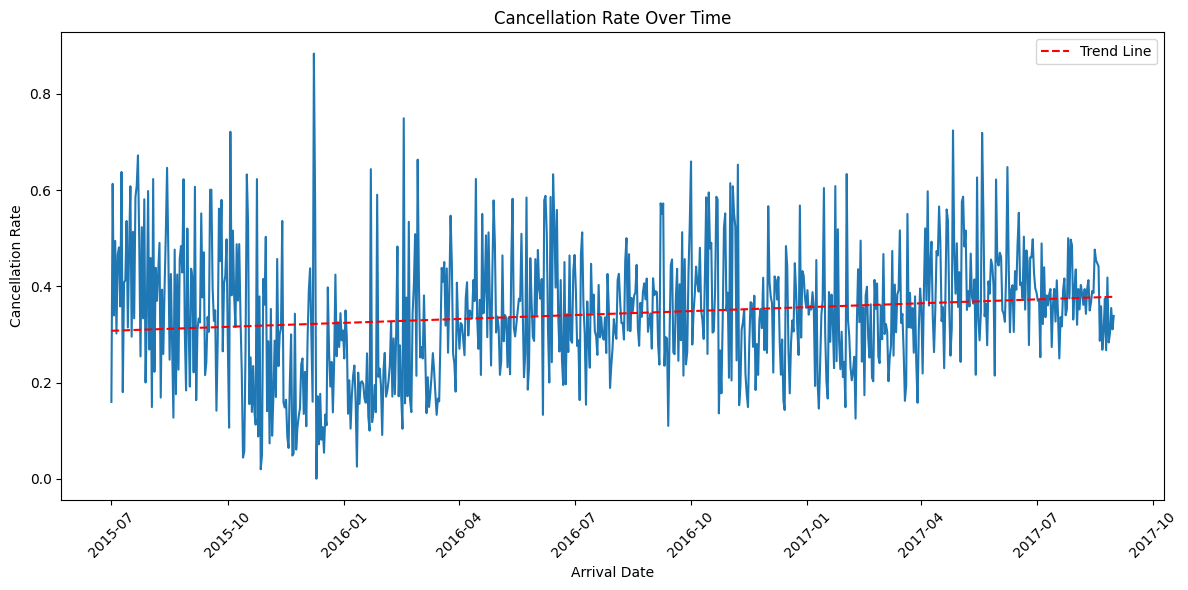

In [49]:
import numpy as np

# Plotting
plt.figure(figsize=(12, 6))

# Line plot for cancellation rate
sns.lineplot(x="arrival_date", y="cancellation_rate", data=cancellation_rate_pd)

# Fit a trend line (linear regression)
# Convert dates to numerical values for fitting
trend_x = np.arange(len(cancellation_rate_pd))
trend_y = np.poly1d(np.polyfit(trend_x, cancellation_rate_pd["cancellation_rate"], 1))(
    trend_x
)
plt.plot(
    cancellation_rate_pd["arrival_date"],
    trend_y,
    color="red",
    linestyle="--",
    label="Trend Line",
)

# Customizing the plot
plt.title("Cancellation Rate Over Time")
plt.xlabel("Arrival Date")
plt.ylabel("Cancellation Rate")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

* The rate of cancelation shows noticeable fluctuations over time, likely influenced by factors such as tourist seasons, holidays, or economic changes.
* The chart indicates that similar booking patterns recur annually, likely reflecting seasonal influences. For example, summer and winter months appear to be peak booking times.
* A notable increase in cancellations is observed in early 2016

##### Monthly Cancelation Rate

In [50]:
from pyspark.sql.functions import mean

# Calculate the cancel rate by month
monthly_cr = df_cleaned.groupBy("month", "hotel").agg(
    mean("is_canceled").alias("cancel_rate")
)
monthly_cr_sorted = monthly_cr.orderBy("month").toPandas()
monthly_cr_sorted

,month,hotel,cancel_rate
0,1,Resort Hotel,0.149765
1,1,City Hotel,0.403067
2,2,Resort Hotel,0.259357
3,2,City Hotel,0.387230
4,3,Resort Hotel,0.231357
5,3,City Hotel,0.373188
6,4,Resort Hotel,0.297153
7,4,City Hotel,0.466143
8,5,Resort Hotel,0.291117
9,5,City Hotel,0.448655


<Axes: xlabel='month', ylabel='cancel_rate'>

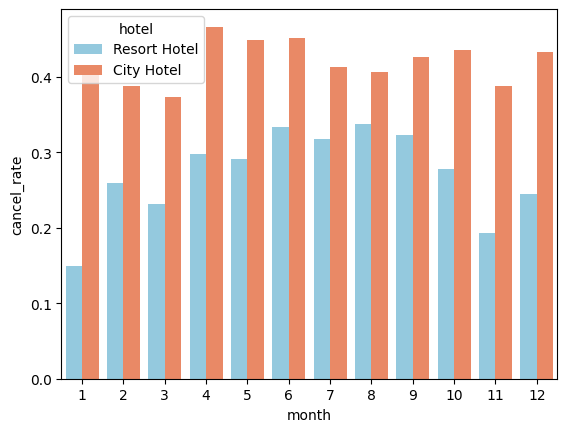

In [51]:
# plotting a bar graph
sns.barplot(
    data=monthly_cr_sorted,
    x="month",
    y="cancel_rate",
    hue="hotel",
    palette=["skyblue", "coral"],
)

The cancellation rate at the city hotel is higher than at the resort hotel. In summer, the rates are almost the same, but the resort shows a lower cancellation rate (meaning more people actually stay) in the early part of the year.

##### Cancelation Based on Origin

In [52]:
# Update the DataFrame
domestic_international = df_cleaned.withColumn(
    "country", F.when(F.col("country") != "PRT", "International").otherwise("Domestic")
)

# Calculate the total count by hotel
dom_inter_count = (
    domestic_international.groupBy("country", "is_canceled").count()
).toPandas()

# Show the resulting DataFrame
dom_inter_count.head(5)

,country,is_canceled,count
0,Domestic,0,19667
1,International,0,53586
2,International,1,16607
3,Domestic,1,27322


<Axes: xlabel='country', ylabel='count'>

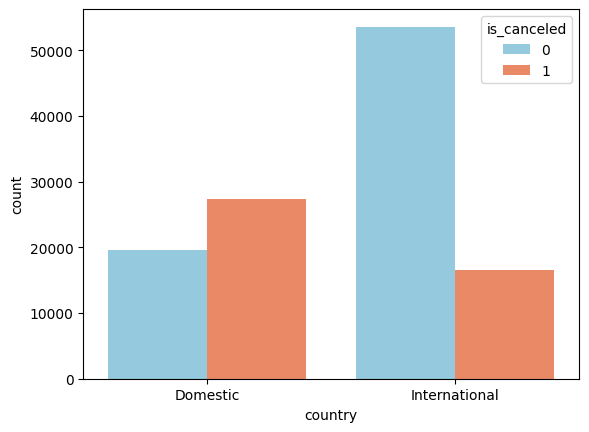

In [53]:
# plotting a bar graph
sns.barplot(
    data=dom_inter_count,
    x="country",
    y="count",
    hue="is_canceled",
    palette=["skyblue", "coral"],
)

Interestingly, the cancellation rate among domestic guests is higher than that among international guests. Most international guests actually stay at their hotels.

##### Average Daily Rate Based on Hotel

In [54]:
from pyspark.sql.functions import mean, stddev, min, max

# Summary statistics
df_stats = df_cleaned.groupBy("hotel").agg(
    mean("adr").alias("mean_adr"),
    stddev("adr").alias("stddev_adr"),
    min("adr").alias("min_adr"),
    max("adr").alias("max_adr"),
)

df_stats.show()

+------------+------------------+------------------+-------+-------+
|       hotel|          mean_adr|        stddev_adr|min_adr|max_adr|
+------------+------------------+------------------+-------+-------+
|Resort Hotel| 96.77138274733832| 60.59328066394977|   0.26|  508.0|
|  City Hotel|106.95330413814226|37.390680944801055|    0.5|  540.0|
+------------+------------------+------------------+-------+-------+



* The average daily rate in resort is approximately €96.77, while in city hotel is €106.95
* The standard deviation is 60.59, indicating a relatively wide variation in prices. This suggests that room rates at the resort fluctuate quite a bit, possibly due to seasonality, different room types, or high demand during peak periods. For city hotel, the standard deviation is 37.39, which is lower than that of the resort. This suggests that room rates at the city hotel are more stable and less prone to large fluctuations


##### Average Daily Rate Based on Room Type

In [55]:
df_adr = (
    df_cleaned.groupBy("reserved_room_type")
    .pivot("hotel")
    .agg(F.avg("adr").alias("average_adr"))
    .toPandas()
)

df_adr_pd = df_adr.sort_values("reserved_room_type")
df_adr_pd

,reserved_room_type,City Hotel,Resort Hotel
6,A,97.607117,77.908818
2,B,95.056918,104.666667
5,C,108.795455,164.218736
4,D,132.816548,104.755962
1,E,161.936069,115.998483
0,F,192.907524,137.872113
7,G,228.204299,171.650342
8,H,NaN,190.121160
3,L,NaN,124.666667


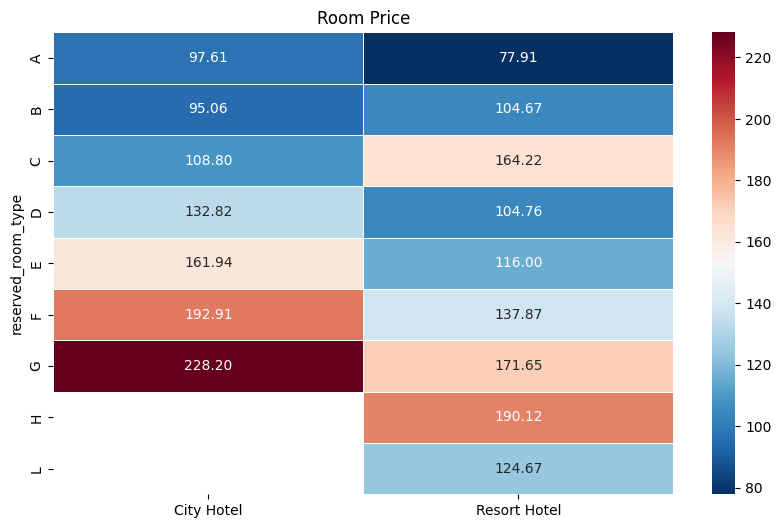

In [56]:
# Set room_type as the index for making monthly heatmap
df_adr_pd.set_index("reserved_room_type", inplace=True)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_adr_pd, annot=True, fmt=".2f", cmap="RdBu_r", linewidths=0.5)
plt.title("Room Price")
plt.show()

* City Hotel generally has higher prices across the board, particularly in the more premium room types (D to G).
Resort Hotel shows more moderate pricing, with less fluctuation between room types, indicating a more consistent pricing strategy.
* Room Type G stands out as the most expensive in both hotels, with City Hotel having the highest price at €228.20 while Room Type A is the least expensive overall in both hotels.
* The Resort Hotel offers Room Types H and L, with prices of €190.12 and €124.67, respectively, which fall between the mid to high range of the room prices for the City Hotel.

##### Price Distribution for Each Room Type

In [57]:
from pyspark.sql.functions import col, min, max, percentile_approx
from pyspark.sql.window import Window

# Determine the highest rate for each room type
adr_room = df_cleaned.select(["reserved_room_type", "adr"])

# Define the window specification
windowSpecAgg = Window.partitionBy("reserved_room_type")

# Compute the five-number summary
df_summary = adr_room.groupBy("reserved_room_type").agg(
    min(col("adr")).alias("min"),
    percentile_approx(col("adr"), 0.25).alias("q1"),
    percentile_approx(col("adr"), 0.5).alias("median"),
    percentile_approx(col("adr"), 0.75).alias("q3"),
    max(col("adr")).alias("max"),
)

df_summary_sorted = df_summary.sort("reserved_room_type")

# Show the results
summary_df = df_summary_sorted.toPandas()
summary_df

,reserved_room_type,min,q1,median,q3,max
0,A,0.50,65.000000,89.099998,112.580002,540.000000
1,B,1.60,77.500000,88.760002,103.690002,284.100006
2,C,8.00,114.300003,164.199997,213.750000,367.000000
3,D,0.26,87.000000,121.500000,150.899994,375.500000
4,E,2.00,79.199997,115.000000,167.000000,451.500000
5,F,2.00,140.800003,177.300003,210.000000,392.000000
6,G,1.00,124.139999,180.000000,240.000000,426.250000
7,H,26.00,130.000000,184.800003,241.000000,437.000000
8,L,8.00,82.000000,136.000000,172.000000,200.000000


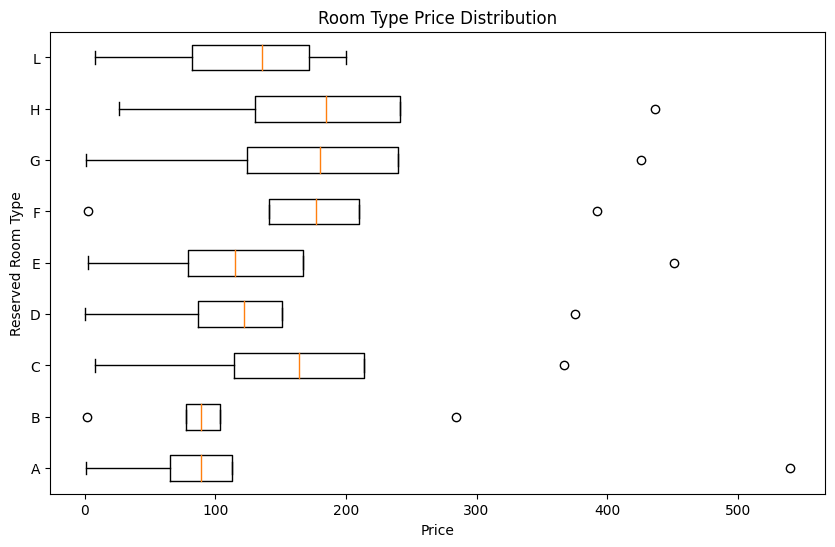

In [58]:
# Create the boxplot
plt.figure(figsize=(10, 6))

# Prepare data in the format required for boxplot (min, q1, median, q3, max)
boxplot_data = [
    [row["min"], row["q1"], row["median"], row["q3"], row["max"]]
    for _, row in summary_df.iterrows()
]

# Create custom boxplot using the pre-calculated stats (min, q1, median, q3, max)
plt.boxplot(boxplot_data, vert=False, labels=summary_df["reserved_room_type"])

# Add title and labels
plt.title("Room Type Price Distribution")
plt.xlabel("Price")
plt.ylabel("Reserved Room Type")

# Show the plot
plt.show()

* While all room types have outliers, indicating considerable price fluctuations, Room Types C, F, G, H, and L exhibit higher variability and broader price ranges.

* Room Type A has a significant outlier, as its maximum price is much higher than its median, reflecting occasional spikes in price. Meanwhile, Room Types F, G, and H have both the highest central tendency and variability, with their medians and quartiles positioned higher than others. Additionally, Room Type L shares a similar trend, with prices ranging from around 100 to over 300, suggesting it is among the more expensive categories, though it lacks as many extreme outliers as Room Type F.

* In contrast, Room Types B and D show less variation, with their prices tightly clustered, reflecting more stable pricing. The outliers in Room Type F and some other categories, however, suggest occasional very high-priced bookings that deviate significantly from the bulk of the data.

* Room types can be grouped into two broad categories: those with relatively stable pricing (like A, B, and D) and those with more volatile and higher prices (like C, F, G, H, and L).

##### Bonus: Does an early reservation give you a better price?

We learned that price fluctuates a lot. It makes me curious whether early booking will give us a cheaper price. Let's check using regplot.

In [59]:
# Get lead vs price to compare
lead_price = df_cleaned.select(["lead_time", "adr"])
lead_price_pd = lead_price.toPandas()
lead_price_pd

,lead_time,adr
0,7,75.000000
1,13,75.000000
2,14,98.000000
3,14,98.000000
4,0,107.000000
...,...,...
117177,23,96.139999
117178,102,225.429993
117179,34,157.710007
117180,109,104.400002


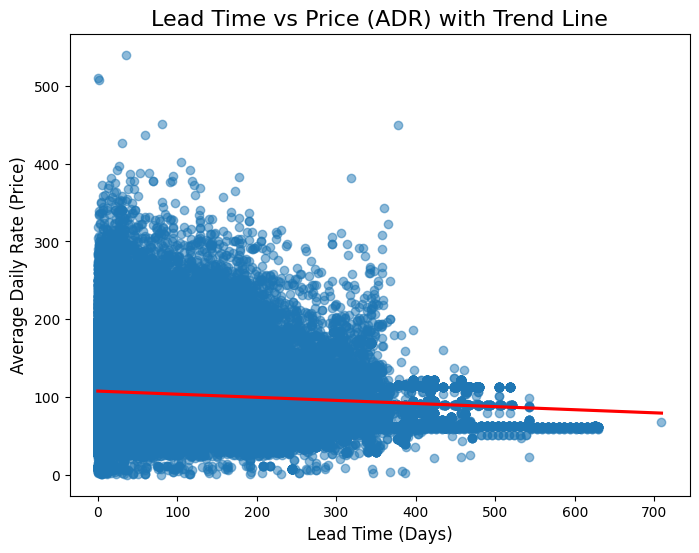

In [60]:
# Set up figure size
plt.figure(figsize=(8, 6))

# Create scatter plot with trend line
sns.regplot(
    x="lead_time",
    y="adr",
    data=lead_price_pd,
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"},
)

# Add labels and title
plt.title("Lead Time vs Price (ADR) with Trend Line", fontsize=16)
plt.xlabel("Lead Time (Days)", fontsize=12)
plt.ylabel("Average Daily Rate (Price)", fontsize=12)

# Show plot
plt.show()

As we can see, while booking early (with a higher lead time) can lead to lower prices, the correlation is low. This means that lead time alone is not a strong predictor of lower prices. We would need to perform regression analysis to explore this further, but I will not be doing that here.

### Conclusion

* Our analysis reveals that `lead_time` and `previous cancellations` are the most crucial factors in determining booking cancellations. A longer lead time and a history of prior cancellations significantly increase the likelihood of a booking being canceled. Additionally, higher booking volumes tend to be associated with more cancellations, indicating that managing large numbers of bookings might contribute to higher cancellation rates. 

* For categorical features, `market_segment` plays big role, with group bookings showing a higher cancellation rate compared to individual bookings. Moreover, cancellation rates are generally higher at city hotels than at resort hotels, and seasonal patterns also influence these rates. Domestic guests are more likely to cancel compared to international guests, who typically honor their bookings. All these numerical and categorical features can help us in feature selection if we want to make further predict whether people will cancel or not. These findings provide valuable insights for improving booking and cancellation management strategies.

* The analysis shows that city hotel room rates average €106.95, higher than the €96.77 average at resort hotels, with the resort exhibiting greater price variability (€60.59 standard deviation) compared to the city hotel (€37.39). City hotels generally have higher, more stable prices, especially in premium room types, while resort hotels offer fluctuating prices depending on the season. 

* Room Type affects the price, as we observe room type G being the most expensive in both hotels, with City Hotel's rate at €228.20. Resort Room Types H and L are priced between the mid to high range of city hotel prices. Significant price fluctuations are noted, especially in Room Types A, C, F, G, H, and L, with Room Type A showing substantial outliers. Conversely, Room Types B and D have more stable pricing. 

* While early booking might sometimes reduce prices, the correlation is weak, indicating that lead time alone is not a strong predictor of lower prices. Further regression analysis would be needed to help predict room price.

## SQL

PySpark SQL is a module in Spark that provides a higher-level abstraction for working with structured data and can be used to run SQL queries. With this API, we will try to explore our guest characteristics to better understand user segmentation and learn about hotel demand in Portugal. For this exercise, I will use plotly to visualize my findings.

### Create Temporary SQL View

In [61]:
# Register the DataFrame as a temporary SQL view
df_cleaned.createOrReplaceTempView("hotelbookings")

### Analysis

#### Analyzing Guest Profiles

In [62]:
# Check the guest who arrived brought children/and baby or not
family = spark.sql(
    """
    SELECT 
        family_status,
        COUNT(*) AS count
    FROM (
        SELECT 
            hotel,
            CASE
                WHEN children > 0 AND babies > 0 THEN 'Family'
                ELSE 'Not Family'
            END AS family_status
        FROM hotelbookings
        WHERE is_canceled = 0
    ) AS filtered_data
    GROUP BY family_status
"""
)

family_pd = family.toPandas()
family_pd

,family_status,count
0,Family,133
1,Not Family,73120


In [63]:
# Import for visualization
import plotly.express as px

# Create pie chart
fig = px.pie(family_pd, values="count", names="family_status")
fig.show()

Observation: 99.8% of guests who showed up didn't bring children/babies, we can say that this hotel is not a family type hotel.

In [64]:
# Check where the guest who arrived come from

country = spark.sql(
    """
    SELECT 
        country,
        sum(adults + children + babies) as guest_count    
    FROM hotelbookings
    WHERE is_canceled = 0
    GROUP BY country
    ORDER BY guest_count DESC
"""
)

country.show(5)

+-------+-----------+
|country|guest_count|
+-------+-----------+
|    PRT|      35494|
|    GBR|      19116|
|    FRA|      17204|
|    ESP|      13096|
|    DEU|      11584|
+-------+-----------+
only showing top 5 rows



Since, our table doesn't have country name, I will join table above with country data.

In [65]:
# Import country data
df_country = spark.read.csv("./data/country.csv", inferSchema=True, header=True)
df_country.show(5)

+--------------+-------+-------+------------+-------------+-------+---------------+-------------------+-----------+---------------+------------------------+
|          name|alpha-2|alpha-3|country-code|   iso_3166-2| region|     sub-region|intermediate-region|region-code|sub-region-code|intermediate-region-code|
+--------------+-------+-------+------------+-------------+-------+---------------+-------------------+-----------+---------------+------------------------+
|   Afghanistan|     AF|    AFG|           4|ISO 3166-2:AF|   Asia|  Southern Asia|               NULL|        142|             34|                    NULL|
| Åland Islands|     AX|    ALA|         248|ISO 3166-2:AX| Europe|Northern Europe|               NULL|        150|            154|                    NULL|
|       Albania|     AL|    ALB|           8|ISO 3166-2:AL| Europe|Southern Europe|               NULL|        150|             39|                    NULL|
|       Algeria|     DZ|    DZA|          12|ISO 3166-2:DZ

In [66]:
country_joined = country.join(
    df_country, country["country"] == df_country["alpha-3"], how="left"
)
country_joined_pd = country_joined.select("country", "name", "guest_count").toPandas()
country_joined_pd.head(5)

,country,name,guest_count
0,POL,Poland,1453
1,LVA,Latvia,91
2,ZMB,Zambia,4
3,JAM,Jamaica,14
4,BRA,Brazil,2967


In [67]:
# Create the choropleth map
fig = px.choropleth(
    country_joined_pd,
    locations="country",
    color="guest_count",
    hover_name="name",
    color_continuous_scale=px.colors.sequential.YlOrRd,
    locationmode="ISO-3",
)

# Update the layout for a better appearance
fig.update_layout(
    title_text="Guest Counts by Country",
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type="equirectangular",
    ),
)

# Show the map
fig.show()

We can observe that guests come from various countries around the world, with Portugal having the highest number, followed by other European countries that are geographically close to Portugal.

#### Reservation Patterns

In [68]:
# Check whether the guests stay on weekday, weekend, or both
night_type = spark.sql(
    """
    SELECT 
        night_type,
        COUNT(*) AS count
    FROM (
        SELECT 
            hotel,
            CASE
                WHEN (stays_in_weekend_nights > 0) AND (stays_in_week_nights = 0) THEN 'Weekend'
                WHEN (stays_in_weekend_nights = 0) AND (stays_in_week_nights > 0) THEN 'Weekday'
                ELSE 'Both'
            END AS night_type
        FROM hotelbookings
        WHERE is_canceled = 0
    ) AS filtered_data
    GROUP BY night_type
"""
)

night_type_pd = night_type.toPandas()
night_type_pd

,night_type,count
0,Both,37238
1,Weekday,31075
2,Weekend,4940


In [69]:
# Create pie chart
fig = px.pie(night_type_pd, values="count", names="night_type")
fig.show()

Reservations indicate a higher demand pattern on weekdays, with a percentage of 93.2% (50.9% solely on weekdays and 42.3% overlapping). This suggests that the hotel may be frequented by business travelers or international tourists who are less influenced by weekend schedules.

In [70]:
# Check the number of day they stay
day_stay = spark.sql(
    """
    SELECT 
        hotel,
        stays_in_weekend_nights + stays_in_week_nights as total_day,
        COUNT(*) as stay_count
    FROM hotelbookings
    WHERE is_canceled = 0
    GROUP BY hotel, total_day
    ORDER BY hotel, total_day
"""
)

day_stay_pd = day_stay.toPandas()
day_stay_pd.head(5)

,hotel,total_day,stay_count
0,City Hotel,1,8759
1,City Hotel,2,10744
2,City Hotel,3,11772
3,City Hotel,4,7643
4,City Hotel,5,3186


In [71]:
# Create the bar chart
fig = px.bar(
    day_stay_pd,
    x="total_day",
    y="stay_count",
    color="hotel",
    title="Number of Stays by Total Days Stayed",
    labels={"total_day": "Total Days Stayed", "stay_count": "Number of Stays"},
    barmode="group",  # Group bars side by side
)

# Set x-axis range (cap at 20 to get rid of outlier)
fig.update_xaxes(range=[0, 20])

# Show the plot
fig.show()

At the City Hotel, most people stay for less than 5 days, with the most common duration being 3 days. At the Resort Hotel, the most common stay is 1 day, but there is also a notable number of guests who stay for 7 days, which is almost as frequent as those staying for 2 days.

In [72]:
# Check whether the reserved room and the assigned room are the same
room_type = spark.sql(
    """
    SELECT 
        room_evaluation,
        COUNT(*) AS count
    FROM (
        SELECT 
            hotel,
            CASE
                WHEN reserved_room_type = assigned_room_type THEN 'Same'
                ELSE 'Different'
            END AS room_evaluation
        FROM hotelbookings
        WHERE is_canceled = 0
    ) AS filtered_data
    GROUP BY room_evaluation
"""
)

room_type_pd = room_type.toPandas()
room_type_pd

,room_evaluation,count
0,Same,59971
1,Different,13282


In [73]:
# Create pie chart
fig = px.pie(room_type_pd, values="count", names="room_evaluation")
fig.show()

From the bookings that have been made, a significant percentage of reserved rooms were not assigned to the guests. This could be due to overbooking; however, the fact that the room was reserved indicates a high demand for that room type. Now, let's check which room type get the most reservation.

In [74]:
# Count number of reservation by room_type
reserved_room = spark.sql(
    """
    SELECT 
        reserved_room_type,
        COUNT(reserved_room_type) as count
    FROM hotelbookings
    WHERE is_canceled = 0
    GROUP BY reserved_room_type
    ORDER BY count
"""
)

reserved_room_pd = reserved_room.toPandas()
reserved_room_pd

,reserved_room_type,count
0,L,4
1,H,350
2,B,595
3,C,607
4,G,1250
5,F,1949
6,E,4517
7,D,12912
8,A,51069


In [75]:
# Create pie chart
fig = px.pie(reserved_room_pd, values="count", names="reserved_room_type")
fig.show()

The most reserved room type is A, followed by D, and E. The demand for type A is significantly high, and if overbooked, it may lead to guest dissatisfaction.

In [76]:
# Cross check reserved room with assigned room
reservation_cross = spark.sql(
    """
    SELECT 
    reserved_room_type,
        COUNT(CASE WHEN assigned_room_type = 'A' THEN 1 END) AS A,
        COUNT(CASE WHEN assigned_room_type = 'B' THEN 1 END) AS B,
        COUNT(CASE WHEN assigned_room_type = 'C' THEN 1 END) AS C,
        COUNT(CASE WHEN assigned_room_type = 'D' THEN 1 END) AS D,
        COUNT(CASE WHEN assigned_room_type = 'E' THEN 1 END) AS E,
        COUNT(CASE WHEN assigned_room_type = 'F' THEN 1 END) AS F,
        COUNT(CASE WHEN assigned_room_type = 'G' THEN 1 END) AS G,
        COUNT(CASE WHEN assigned_room_type = 'H' THEN 1 END) AS H,
        COUNT(CASE WHEN assigned_room_type = 'L' THEN 1 END) AS L,
        COUNT(CASE WHEN assigned_room_type = 'P' THEN 1 END) AS P
FROM
    hotelbookings
GROUP BY
    reserved_room_type
ORDER BY
    reserved_room_type
"""
)

reservation_pd = reservation_cross.toPandas()
reservation_pd

,reserved_room_type,A,B,C,D,E,F,G,H,L,P
0,A,72778,1089,1411,7335,1111,382,173,88,0,0
1,B,80,783,0,4,2,2,8,0,0,0
2,C,4,2,874,6,3,1,10,9,0,0
3,D,293,25,32,17629,677,197,80,9,0,0
4,E,11,2,7,19,5862,395,93,3,0,0
5,F,3,12,0,2,31,2656,110,3,0,0
6,G,4,1,1,0,1,12,1969,7,0,0
7,H,0,0,0,1,0,0,10,580,0,0
8,L,1,1,1,0,0,1,0,1,1,0


In [77]:
fig = px.bar(
    reservation_pd,
    x="reserved_room_type",
    y=["A", "B", "C", "D", "E", "F", "G", "H", "L", "P"],
    title="Stacked Bar Chart of Reserved vs Assigned Room Types",
)
fig.show()

In [78]:
# Run SQL query to get meal counts
df_meal_sql = spark.sql(
    """
    SELECT 
        hotel, 
        meal, 
        COUNT(meal) AS meal_count
    FROM hotelbookings
    WHERE is_canceled = 0
    GROUP BY hotel, meal
"""
)

In [79]:
# Find the most common meal for each hotel
df_most_common_meal_sql = spark.sql(
    """
    WITH meal_counts AS (
        SELECT 
            hotel, 
            meal, 
            COUNT(meal) AS meal_count
        FROM hotelbookings
        GROUP BY hotel, meal
    ),
    ranked_meals AS (
        SELECT 
            hotel, 
            meal, 
            meal_count,
            ROW_NUMBER() OVER (PARTITION BY hotel ORDER BY meal_count DESC) AS rank
        FROM meal_counts
    )
    SELECT 
        hotel, 
        meal AS most_common_meal, 
        meal_count
    FROM ranked_meals
    WHERE rank = 1
"""
)

# Show the result
df_most_common_meal_sql.show()

+------------+----------------+----------+
|       hotel|most_common_meal|meal_count|
+------------+----------------+----------+
|  City Hotel|              BB|     61146|
|Resort Hotel|              BB|     29451|
+------------+----------------+----------+



#### Hotel Demand Analysis

In [80]:
# Number of Guest over time for each hotel
month_year = spark.sql(
    """
    SELECT 
        hotel,
        arrival_date_year as year,
        month,
        sum(adults + children + babies) as guests,
        median(adr) as price
    FROM hotelbookings
    GROUP BY arrival_date_year, month, hotel
    ORDER BY arrival_date_year, month
"""
)

month_year_pd = month_year.toPandas()
month_year_pd.head(5)

,hotel,year,month,guests,price
0,Resort Hotel,2015,7,2984,123.000000
1,City Hotel,2015,7,2629,62.799999
2,Resort Hotel,2015,8,3116,154.000000
3,City Hotel,2015,8,4776,75.000000
4,Resort Hotel,2015,9,3064,79.915001


In [81]:
# Concate month and year
month_year_pd["month_year"] = (
    month_year_pd["month"].astype(str) + "-" + month_year_pd["year"].astype(str)
)

# Create a line chart for number of guests over time
fig = px.line(
    month_year_pd,
    x="month_year",
    y="guests",
    title="Number of Guests Over Time",
    labels={"month_year": "Month-Year", "guests": "Number of Guests"},
    markers=True,
    color="hotel",
)
# Show the plot
fig.show()

The chart reveals a clear seasonal pattern, with both hotels experiencing a decline in guest numbers during the winter months. Interestingly, while the resort maintains a relatively stable guest count throughout the year, the fluctuations at the other hotel are more pronounced. This indicates that, despite seasonal variations, the resort's appeal remains consistent over time.

Recalling previous observations, we understand that most guests stay during weekdays. It is therefore logical that, during winter (winter holidays), they are less likely to stay at city hotels.

In [82]:
# # Create a line chart for average monthly rate for each hotel
fig = px.line(
    month_year_pd,
    x="month_year",
    y="price",
    title="Average Monthly Rate by Hotel",
    labels={"month_year": "Month-Year", "price": "Hotel Rate"},
    markers=True,
    color="hotel",
)
# Show the plot
fig.show()

Now, we can observe that the price of the resort fluctuates significantly compared to the city hotel. The city hotel rate remains relatively stable, with only a slight increase over time, while the resort experiences dramatic fluctuations, particularly during the summer months. This is entirely logical, given that Portugal is one of the most visited destinations during the summer.

In [83]:
price_demand = spark.sql(
    """
    SELECT 
        arrival_date_year as year,
        month,
        sum(adults + children + babies) as guests,
        median(adr) as price
    FROM hotelbookings
    GROUP BY arrival_date_year, month
    ORDER BY arrival_date_year, month
"""
)

price_demand_pd = price_demand.toPandas()
price_demand_pd.head(5)

,year,month,guests,price
0,2015,7,5613,91.350002
1,2015,8,7892,94.500000
2,2015,9,9358,89.250000
3,2015,10,8755,76.465000
4,2015,11,3701,64.000000


In [84]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

price_demand_pd["month_year"] = (
    price_demand_pd["month"].astype(str) + "-" + price_demand_pd["year"].astype(str)
)

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(
        x=price_demand_pd["month_year"],
        y=price_demand_pd["price"],
        name="price",
        mode="lines+markers",
        marker={"color": "coral"},
    ),
    secondary_y=True,
)

fig.add_trace(
    go.Bar(
        x=price_demand_pd["month_year"],
        y=price_demand_pd["guests"],
        name="guest_count",
        marker={"color": "skyblue"},
    ),
    secondary_y=False,
)

# Add figure title
fig.update_layout(title_text="Demand Insights: Price Fluctuations and Guest Counts")

# Set x-axis title
fig.update_xaxes(title_text="Month-Year")

# Set y-axes titles
fig.update_yaxes(title_text="Price", secondary_y=False)
fig.update_yaxes(title_text="Number of Guests", secondary_y=True)

fig.show()

As we know, with the same supply, an increase in demand typically drives up prices. This trend is observable in the graph above. However, it is particularly noteworthy that despite a significant number of visitors in 2015, prices remained relatively stable. To make informed decisions about the rates, we need to check the average price for each month by the hotel.

In [85]:
# Average price for each month by the hotel
price_demand_hotel = spark.sql(
    """
    SELECT 
        month,
        hotel,
        sum(adults + children + babies) as guests,
        median(adr) as price
    FROM hotelbookings
    GROUP BY month, hotel
    ORDER BY month
"""
)

price_demand_hotel.show(5)

+-----+------------+------+-----+
|month|       hotel|guests|price|
+-----+------------+------+-----+
|    1|Resort Hotel|  3701| 48.0|
|    1|  City Hotel|  6596| 80.0|
|    2|Resort Hotel|  5829| 52.0|
|    2|  City Hotel|  9221| 80.0|
|    3|Resort Hotel|  5995| 56.0|
+-----+------------+------+-----+
only showing top 5 rows



In [86]:
price_demand_city = price_demand_hotel.filter(price_demand_hotel.hotel == "City Hotel")
price_demand_city_pd = price_demand_city.toPandas()

price_demand_resort = price_demand_hotel.filter(
    price_demand_hotel.hotel == "Resort Hotel"
)
price_demand_resort_pd = price_demand_resort.toPandas()

hotel_list = [price_demand_city_pd, price_demand_resort_pd]

In [87]:
# Create subplot
fig = make_subplots(
    rows=1,
    cols=2,
    subplot_titles=("City Hotel", "Resort Hotel"),
    specs=[
        [{"secondary_y": True}, {"secondary_y": True}]
    ],  # Secondary y-axis in both subplots
)

# Loop through hotel dataframes to create subplots
for i, hotel in enumerate(hotel_list):
    fig.add_trace(
        go.Scatter(
            x=hotel["month"],
            y=hotel["price"],
            name=f"Price - {'City' if i == 0 else 'Resort'}",
            mode="lines+markers",
            marker={"color": "coral"},
        ),
        row=1,
        col=i + 1,
        secondary_y=True,
    )

    fig.add_trace(
        go.Bar(
            x=hotel["month"],
            y=hotel["guests"],
            name=f"Guest Count - {'City' if i == 0 else 'Resort'}",
            marker={"color": "skyblue"},
        ),
        row=1,
        col=i + 1,
        secondary_y=False,
    )

# Add figure title
fig.update_layout(
    title_text="Price Fluctuations and Guest Counts Based on the Hotel",
    showlegend=False,
)

# Set x-axis titles for both subplots
fig.update_xaxes(title_text="Month", row=1, col=1)
fig.update_xaxes(title_text="Month", row=1, col=2)

# Set y-axes titles for both subplots
fig.update_yaxes(title_text="Guest Count", secondary_y=False, row=1, col=1)
fig.update_yaxes(title_text="Price", secondary_y=True, row=1, col=2)

# Show the figure
fig.show()

There is a difference in the average price for each month at the hotel. In the city hotel, there were times when the price increased even though the number of guests did not. Meanwhile, at the resort, there were times when the price remained low despite an increase in guest count.

### Conclusion
* Both hotels are primarily frequented by guests without children or babies. Visitors come from a variety of countries, with domestic guests from Portugal being the most prevalent, followed by guests from Western European countries such as the UK, France, and Germany.

* Most guests stay for less than 5 days. At City Hotel, the most common duration is 3 days. At the Resort Hotel, the most common stay is 1 day, but there is also a notable number of guests who stay for 7 days, which is almost as frequent as those staying for 2 days.

* Reservations show a higher demand pattern on weekdays, with Room Type A being the most frequently reserved. However, approximately 30% of reservations for Room Type A have been reassigned to other room types.

* There is a clear seasonal pattern, with a decrease in the number of guests during winter and an increase afterward. The resort's pricing generally follows demand but exhibits significant fluctuations, particularly during summer, with variations surpassing those of the City Hotel. It is suggested that the business owner consider capitalizing on the opportunity to increase prices in the months leading up to summer, as guest numbers during these months are nearly as high as in summer.